In [1]:
%matplotlib inline

import numpy as np
import copy


import matplotlib.pyplot as plt
import pickle
import random
import torch
from utils import torch_from_numpy
import datetime

from config import cfg_seed, cfg_env, cfg_z_dim, cfg_default_lr, cfg_default_early, cfg_policy_evaluation_maxiter
seed = cfg_seed
env_str=cfg_env
default_lr=cfg_default_lr
default_early=cfg_default_early

from config import cfg_alpha
alpha=cfg_alpha

num_iter_max=200000
env_name = 'CustomCartPole-v0'
env_str=cfg_env
figfilenamehead = "fig_policy_optimization_"+env_str+"_iter1_"

loss_list = []
normalized_loss_list = []

policy_evaluation_maxiter = cfg_policy_evaluation_maxiter
print("policy_evaluation_maxiter",policy_evaluation_maxiter)
print("alpha",alpha)
print("seed",seed)
print(datetime.datetime.now())

policy_evaluation_maxiter 5
alpha 0.1
seed 1
2023-07-30 20:37:36.702355


In [2]:
import gym
import custom_gym
env = gym.make(env_name)

np.random.seed(seed)
random.seed(seed)
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)

s_dim = env.reset().flatten().shape[0]
a_dim = env.action_space.sample().flatten().shape[0]
z_dim = cfg_z_dim
print(s_dim, a_dim, z_dim)



4 1 2


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:268: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [3]:


from sac import SAC
# agent = SAC(env.observation_space.shape[0], env.action_space)
agent = SAC(env.observation_space.shape[0]+z_dim*2, env.action_space)
agent.load_checkpoint(ckpt_path="checkpoints/sac_checkpoint_custom_"+env_str+"_bamdp_standardvae_")


offline_data = pickle.load(open("offline_data_"+env_str+".pkl","rb"))
debug_info = pickle.load(open("offline_data_debug_info_"+env_str+".pkl","rb"))
debug_info = np.array(debug_info)

Loading models from checkpoints/sac_checkpoint_custom_cartpole_bamdp_standardvae_


In [4]:
args_init_dict = {
    "offline_data": offline_data,
    "s_dim": s_dim,
    "a_dim": a_dim,
    "z_dim": z_dim,
    #              "policy":agent.select_action,
    "mdp_policy":None,
    "bamdp_policy":agent.policy.my_np_select_action,
    "debug_info":debug_info,
    "env" : env,
    "ckpt_suffix" : env_str,
}
# import vi_base
# vi = vi_base.baseVI(args_init_dict)
import vi_iw
iwvi = vi_iw.iwVI(args_init_dict)

iwvi.load_base(ckpt_key="unweighted")
# iwvi.update_mulogvar_offlinedata()

dec: h_dim 64
base load ckpt ckpt_basevi_cartpole_unweighted
base load self.initial_belief.data.sum() tensor(-4.7190)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(-5.4964)
penalty_target_min tensor(-11.3380) penalty_target_max tensor(7.8557)
train_loss:  -8.237324515533448
valid_loss:  -7.70716544342041
h_min_tilde -11.33799 ell_tilde -8.13129270111084 kappa_tilde 0.0005584329428254637


In [5]:
iwvi.get_real_rollout_bamdppolicy_data()


 0 1.430511474609375e-06


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):



 1 6.48772406578064

 2 6.675163269042969

 3 6.809498071670532

 4 6.9142374992370605

 5 3.7692344188690186

 6 3.3139548301696777

 7 3.2885711193084717

 8 3.3893682956695557

 9 3.4511728286743164

 10 3.4807498455047607

 11 3.6506617069244385

 12 3.42034912109375

 13 3.4391074180603027

 14 3.341163158416748

 15 3.390280246734619

 16 3.5193233489990234

 17 3.478807210922241

 18 3.433133840560913

 19 3.4850351810455322

 20 3.3954546451568604

 21 3.444296360015869

 22 3.605241537094116

 23 3.3843183517456055

 24 3.4685239791870117

 25 3.4337594509124756

 26 3.6107866764068604

 27 3.4699084758758545

 28 3.331017017364502

 29 3.435612440109253

 30 3.453399896621704

 31 3.560331344604492

 32 3.638824701309204

 33 3.3072783946990967

 34 5.347047805786133

 35 7.015882253646851

 36 3.777703285217285

 37 3.5638091564178467

 38 4.2389140129089355

 39 3.461667776107788

 40 3.5426154136657715

 41 3.528355836868286

 42 3.7279958724975586

 43 3.4194509983062744

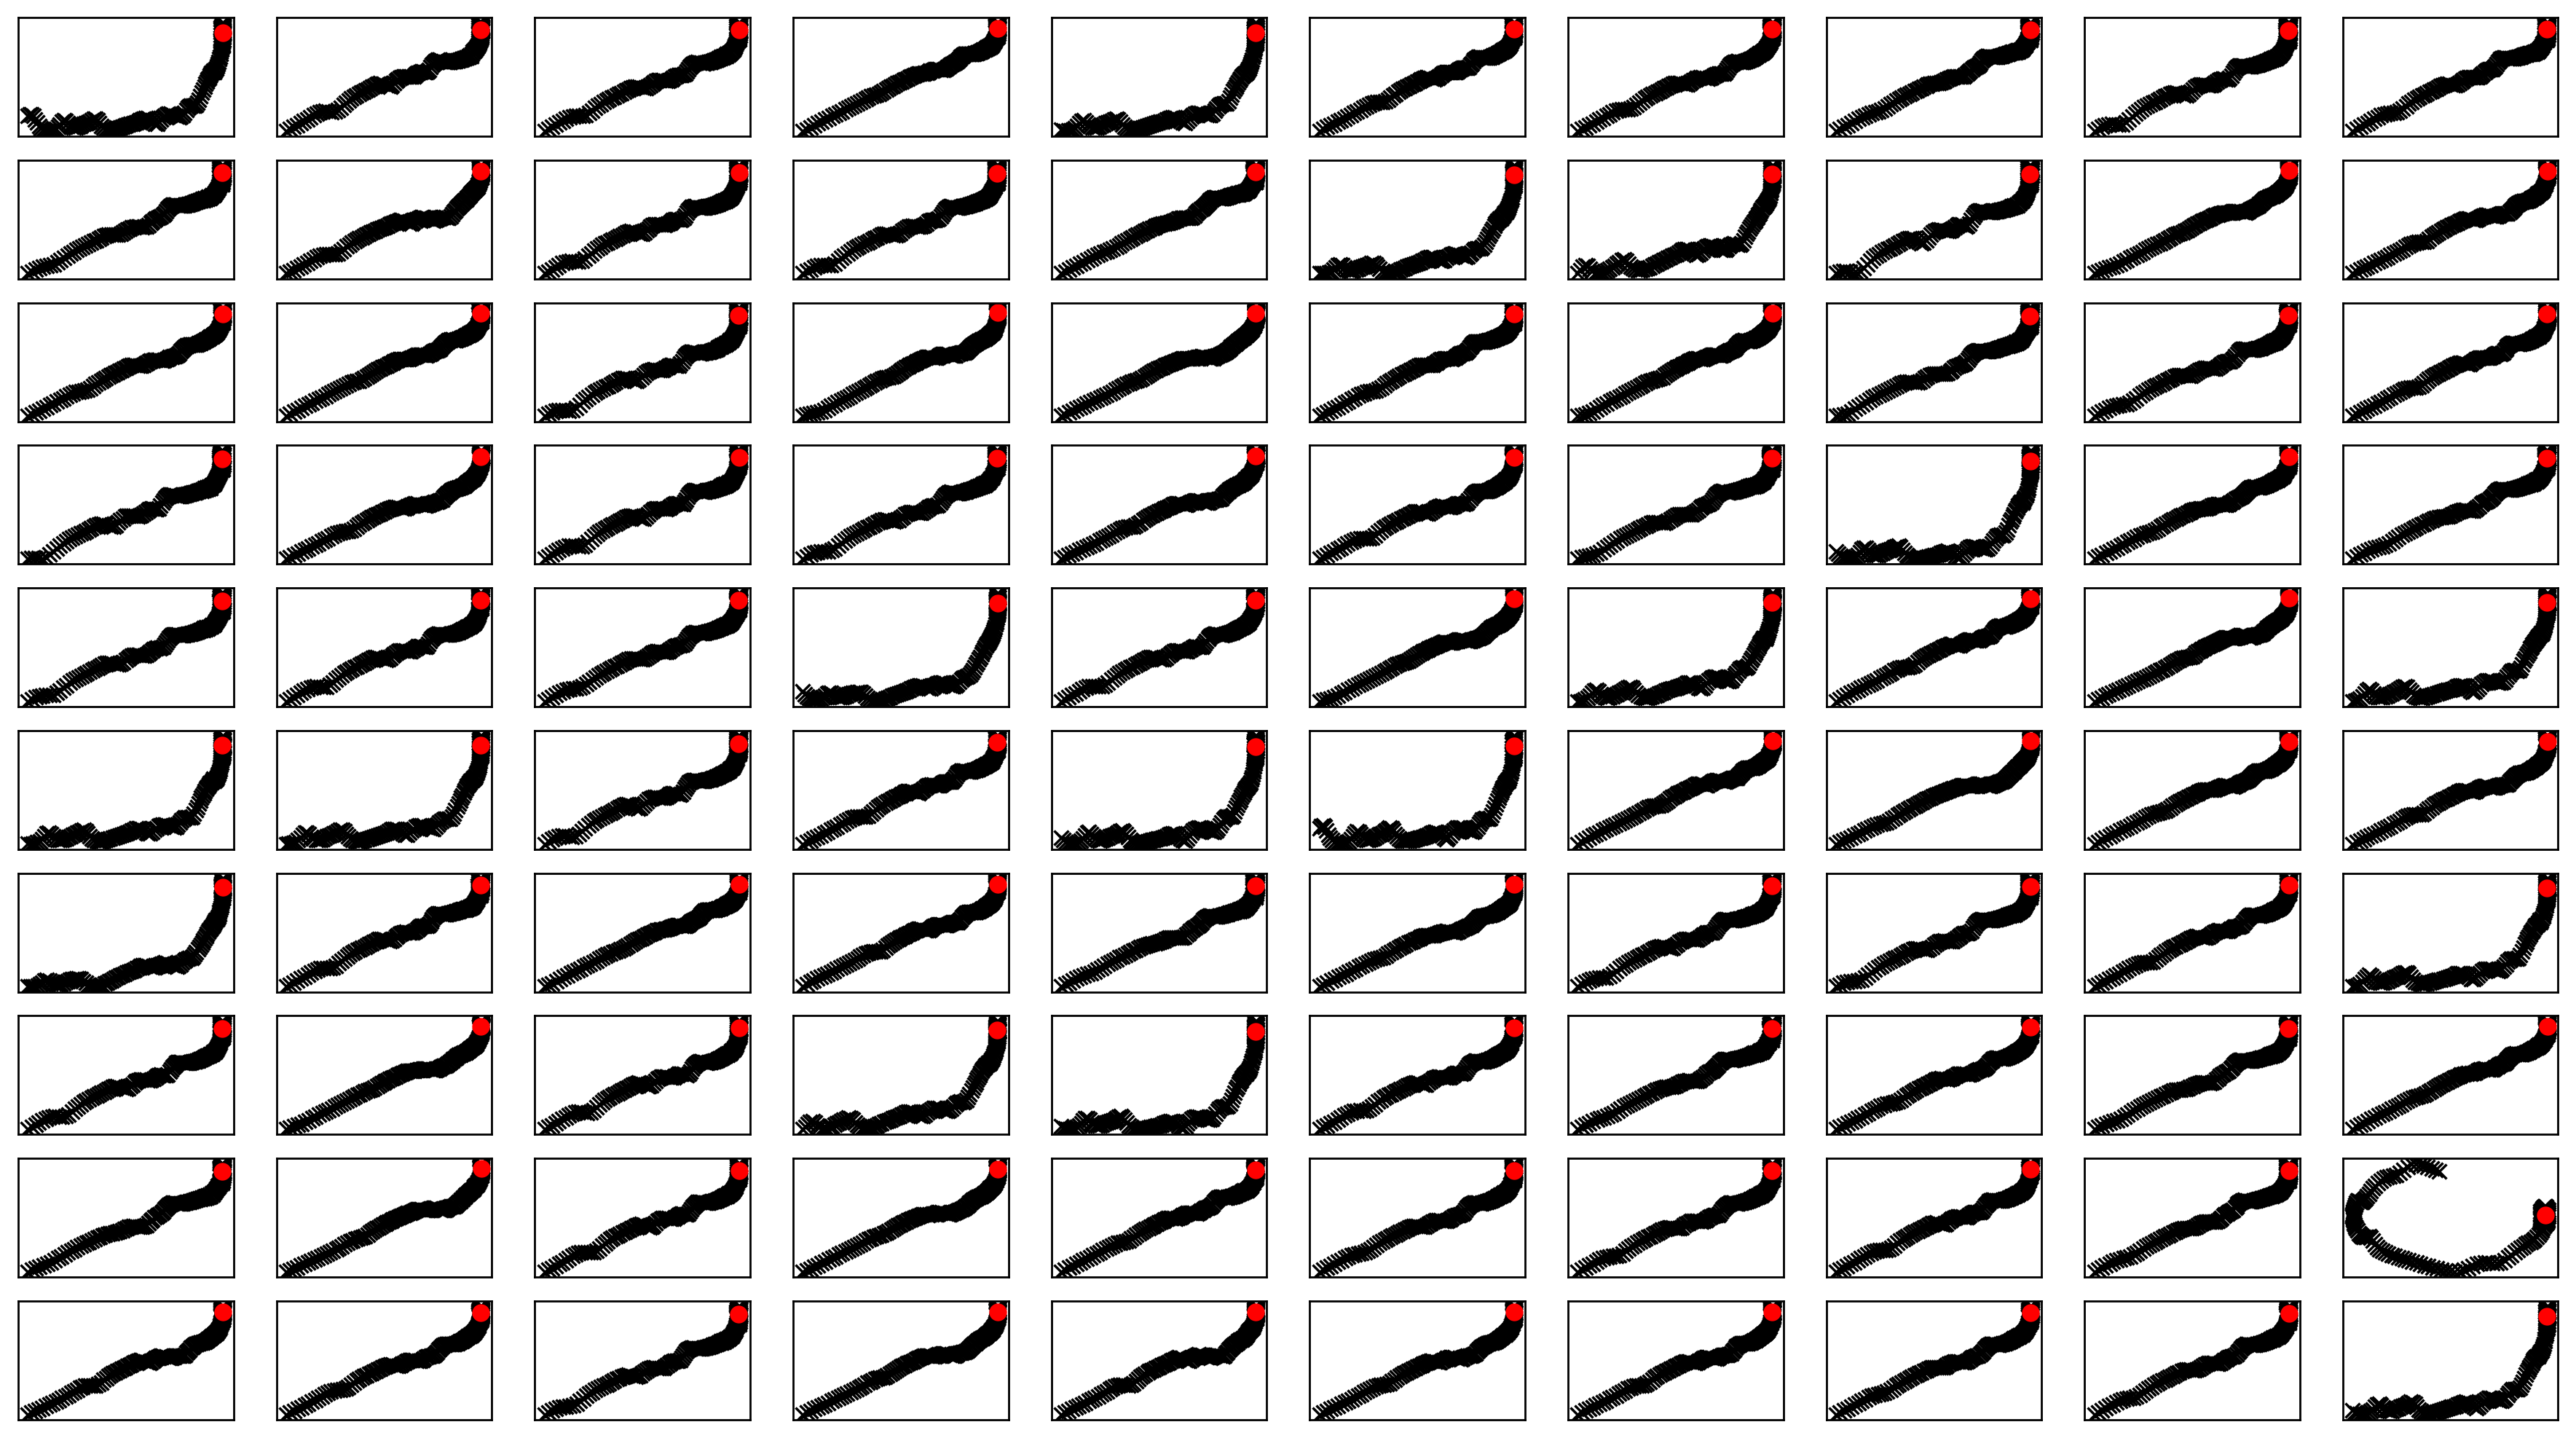

In [6]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

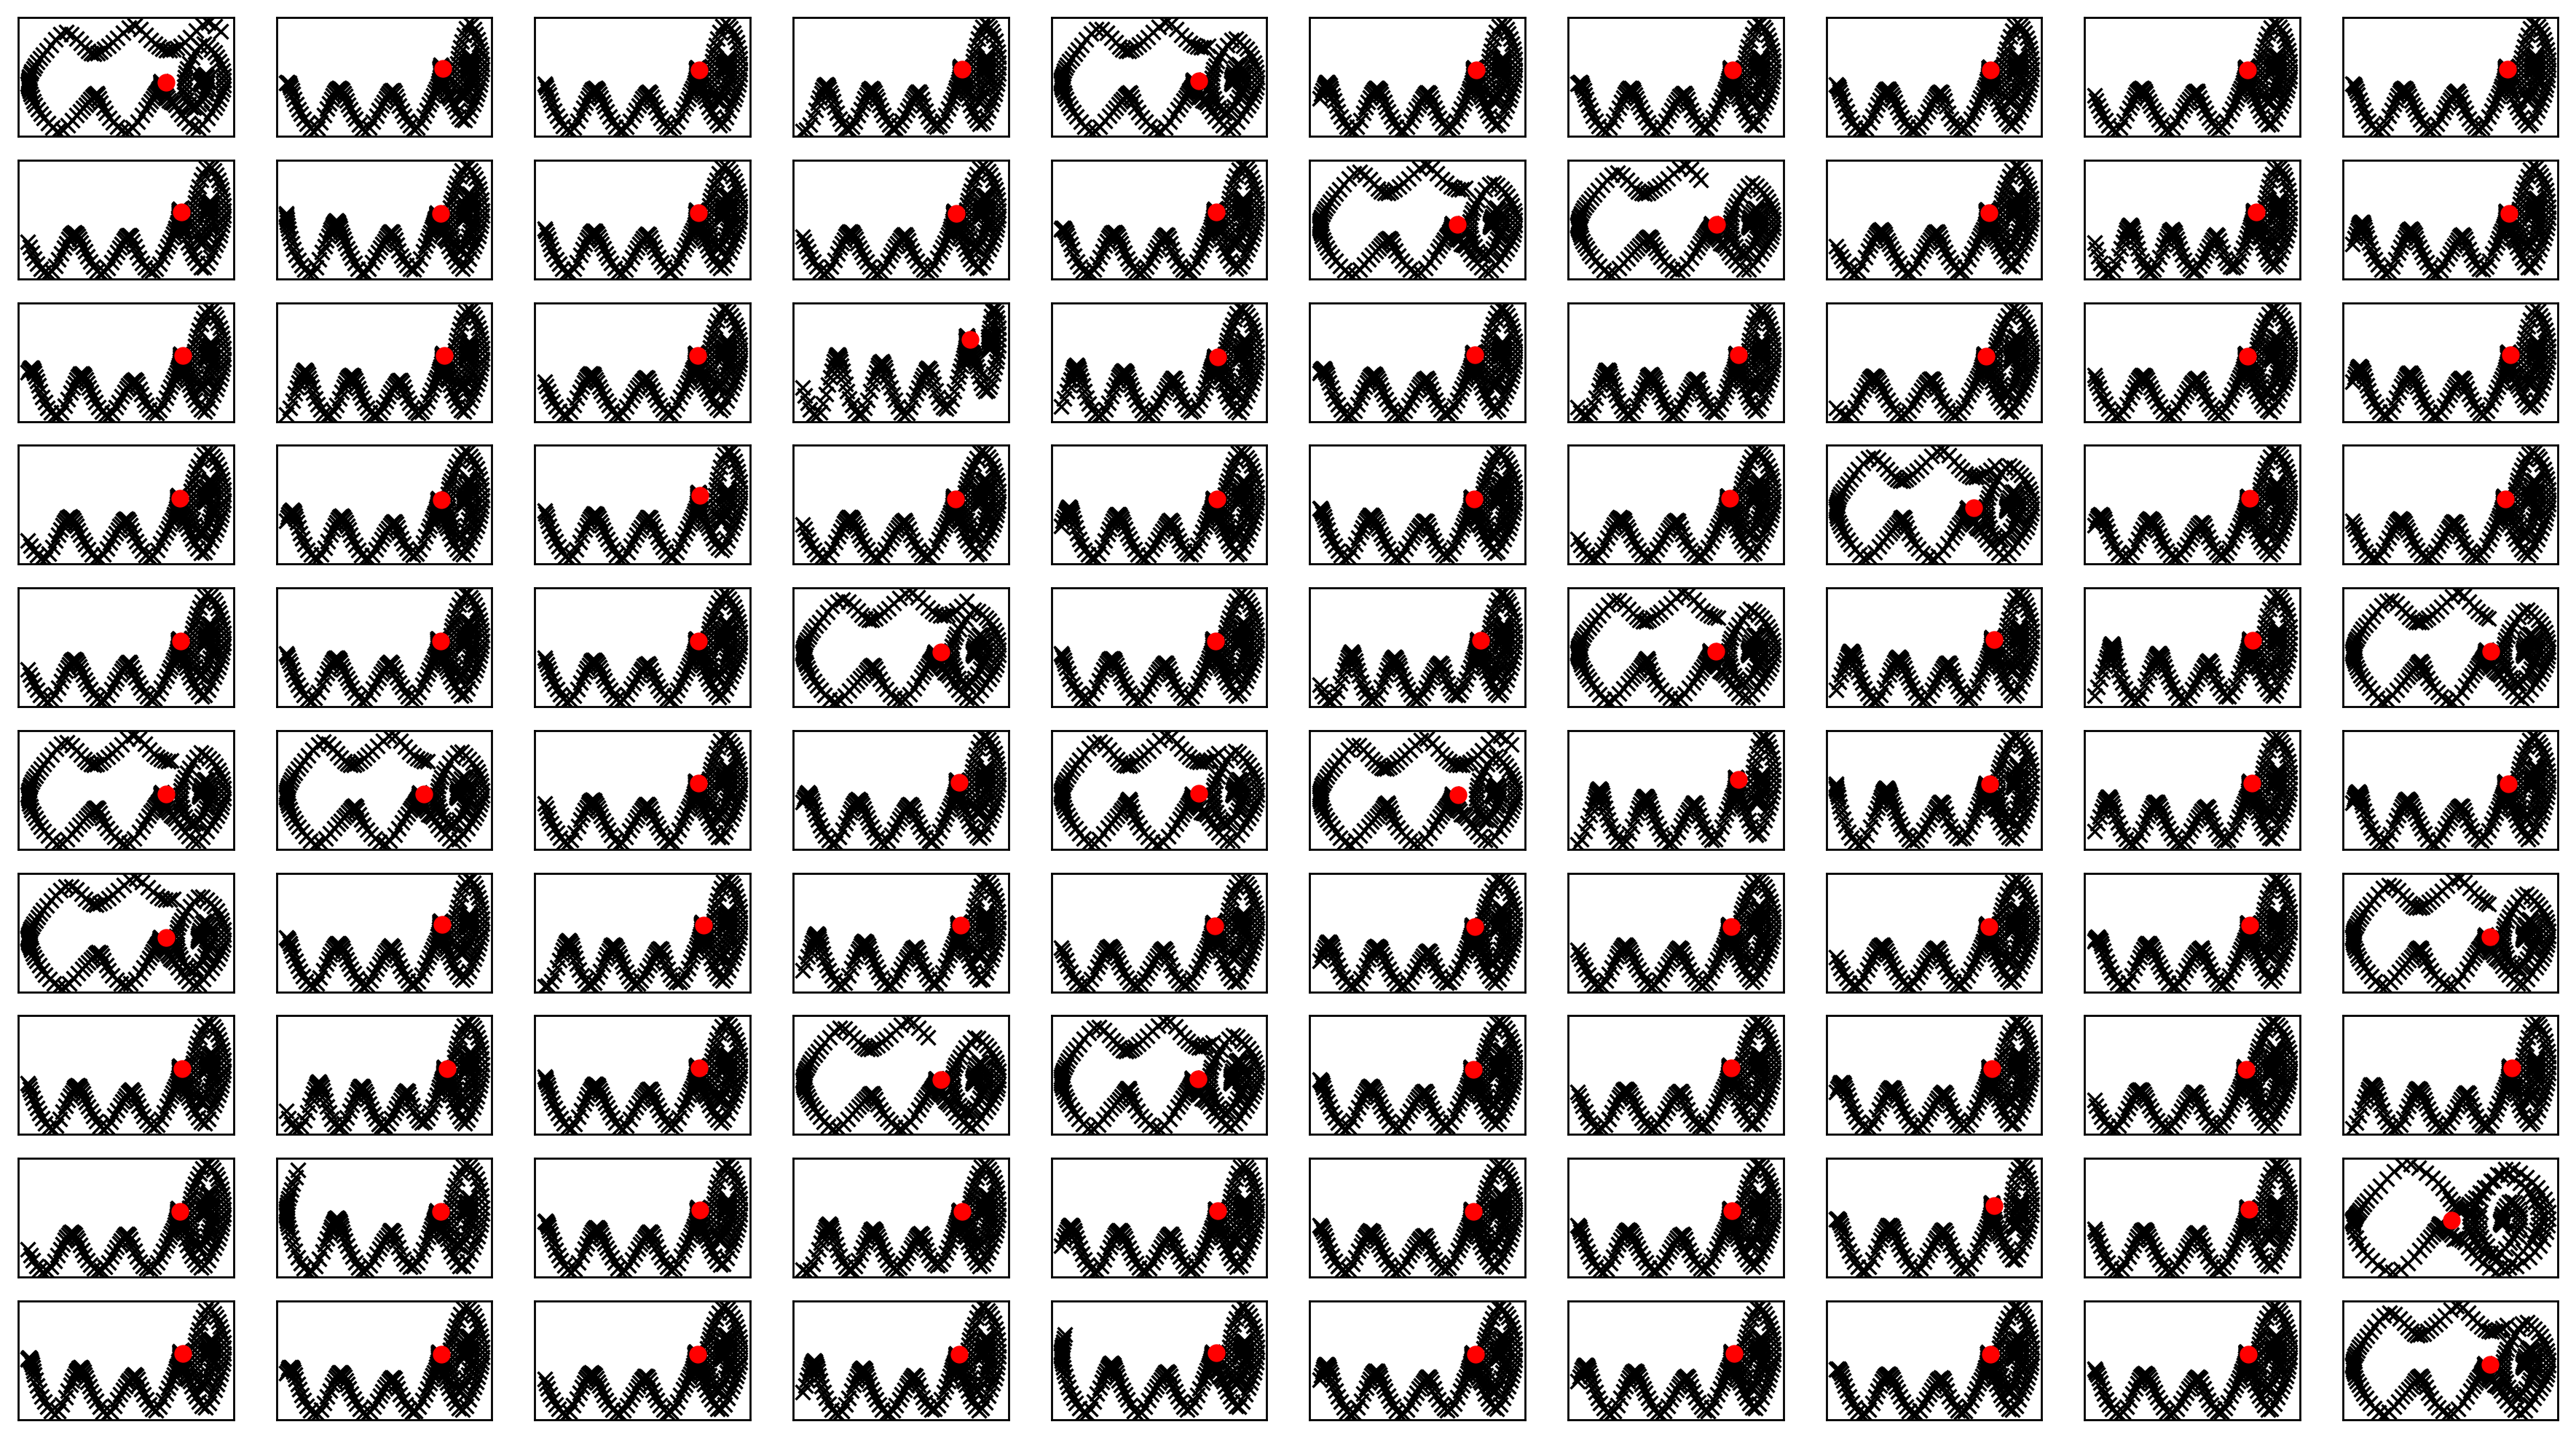

In [7]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,2], iwvi.debug_realenv_rolloutdata[i][:,3],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

In [8]:
print(datetime.datetime.now())

2023-07-30 20:44:58.824096


# Iter 1

In [9]:
policy_evaluation_iter=0

In [10]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [11]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 1.33901  validloss 1.41106±0.00000  bestvalidloss 1.41106  last_update 0
train: iter 1  trainloss 1.22145  validloss 1.29677±0.00000  bestvalidloss 1.29677  last_update 0
train: iter 2  trainloss 1.11329  validloss 1.22562±0.00000  bestvalidloss 1.22562  last_update 0
train: iter 3  trainloss 0.98439  validloss 1.12056±0.00000  bestvalidloss 1.12056  last_update 0
train: iter 4  trainloss 0.86444  validloss 0.99053±0.00000  bestvalidloss 0.99053  last_update 0
train: iter 5  trainloss 0.78225  validloss 0.86193±0.00000  bestvalidloss 0.86193  last_update 0
train: iter 6  trainloss 0.71838  validloss 0.79020±0.00000  bestvalidloss 0.79020  last_update 0
train: iter 7  trainloss 0.67095  validloss 0.70913±0.00000  bestvalidloss 0.70913  last_update 0
train: iter 8  trainloss 0.63537  validloss 0.67407±0.00000  bestvalidloss 0.67407  last_update 0
train: iter 9  trainloss 0.61172  validloss 0.63262±0.00000  bestvalidloss 0.63262  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.38789  validloss 0.44021±0.00000  bestvalidloss 0.40912  last_update 2
train: iter 84  trainloss 0.38225  validloss 0.42768±0.00000  bestvalidloss 0.40912  last_update 3
train: iter 85  trainloss 0.37375  validloss 0.41079±0.00000  bestvalidloss 0.40912  last_update 4
train: iter 86  trainloss 0.38232  validloss 0.40900±0.00000  bestvalidloss 0.40900  last_update 0
train: iter 87  trainloss 0.37967  validloss 0.41190±0.00000  bestvalidloss 0.40900  last_update 1
train: iter 88  trainloss 0.37527  validloss 0.42650±0.00000  bestvalidloss 0.40900  last_update 2
train: iter 89  trainloss 0.37577  validloss 0.41365±0.00000  bestvalidloss 0.40900  last_update 3
train: iter 90  trainloss 0.37540  validloss 0.41052±0.00000  bestvalidloss 0.40900  last_update 4
train: iter 91  trainloss 0.38416  validloss 0.41289±0.00000  bestvalidloss 0.40900  last_update 5
train: iter 92  trainloss 0.37304  validloss 0.42127±0.00000  bestvalidloss 0.40900  last_update 6
train: ite

train: iter 165  trainloss 0.34875  validloss 0.39708±0.00000  bestvalidloss 0.38286  last_update 2
train: iter 166  trainloss 0.35269  validloss 0.38238±0.00000  bestvalidloss 0.38238  last_update 0
train: iter 167  trainloss 0.35585  validloss 0.38915±0.00000  bestvalidloss 0.38238  last_update 1
train: iter 168  trainloss 0.34598  validloss 0.39732±0.00000  bestvalidloss 0.38238  last_update 2
train: iter 169  trainloss 0.34962  validloss 0.38660±0.00000  bestvalidloss 0.38238  last_update 3
train: iter 170  trainloss 0.35003  validloss 0.39173±0.00000  bestvalidloss 0.38238  last_update 4
train: iter 171  trainloss 0.34538  validloss 0.39205±0.00000  bestvalidloss 0.38238  last_update 5
train: iter 172  trainloss 0.35133  validloss 0.38675±0.00000  bestvalidloss 0.38238  last_update 6
train: iter 173  trainloss 0.34945  validloss 0.39784±0.00000  bestvalidloss 0.38238  last_update 7
train: iter 174  trainloss 0.34693  validloss 0.40928±0.00000  bestvalidloss 0.38238  last_update 8


train: iter 247  trainloss 0.32928  validloss 0.37770±0.00000  bestvalidloss 0.36969  last_update 3
train: iter 248  trainloss 0.32910  validloss 0.39289±0.00000  bestvalidloss 0.36969  last_update 4
train: iter 249  trainloss 0.33376  validloss 0.37395±0.00000  bestvalidloss 0.36969  last_update 5
train: iter 250  trainloss 0.32994  validloss 0.38285±0.00000  bestvalidloss 0.36969  last_update 6
train: iter 251  trainloss 0.32927  validloss 0.37989±0.00000  bestvalidloss 0.36969  last_update 7
train: iter 252  trainloss 0.33030  validloss 0.37061±0.00000  bestvalidloss 0.36969  last_update 8
train: iter 253  trainloss 0.32980  validloss 0.39191±0.00000  bestvalidloss 0.36969  last_update 9
train: iter 254  trainloss 0.32646  validloss 0.36910±0.00000  bestvalidloss 0.36910  last_update 0
train: iter 255  trainloss 0.33024  validloss 0.38142±0.00000  bestvalidloss 0.36910  last_update 1
train: iter 256  trainloss 0.32867  validloss 0.38227±0.00000  bestvalidloss 0.36910  last_update 2


train: iter 329  trainloss 0.31132  validloss 0.35925±0.00000  bestvalidloss 0.35717  last_update 1
train: iter 330  trainloss 0.30833  validloss 0.35822±0.00000  bestvalidloss 0.35717  last_update 2
train: iter 331  trainloss 0.31445  validloss 0.36379±0.00000  bestvalidloss 0.35717  last_update 3
train: iter 332  trainloss 0.30844  validloss 0.35915±0.00000  bestvalidloss 0.35717  last_update 4
train: iter 333  trainloss 0.31374  validloss 0.36767±0.00000  bestvalidloss 0.35717  last_update 5
train: iter 334  trainloss 0.31167  validloss 0.36225±0.00000  bestvalidloss 0.35717  last_update 6
train: iter 335  trainloss 0.30795  validloss 0.36184±0.00000  bestvalidloss 0.35717  last_update 7
train: iter 336  trainloss 0.31048  validloss 0.36203±0.00000  bestvalidloss 0.35717  last_update 8
train: iter 337  trainloss 0.30938  validloss 0.37144±0.00000  bestvalidloss 0.35717  last_update 9
train: iter 338  trainloss 0.30959  validloss 0.37361±0.00000  bestvalidloss 0.35717  last_update 10

train: iter 411  trainloss 0.29882  validloss 0.35977±0.00000  bestvalidloss 0.35103  last_update 6
train: iter 412  trainloss 0.29633  validloss 0.35680±0.00000  bestvalidloss 0.35103  last_update 7
train: iter 413  trainloss 0.29124  validloss 0.36485±0.00000  bestvalidloss 0.35103  last_update 8
train: iter 414  trainloss 0.29576  validloss 0.35394±0.00000  bestvalidloss 0.35103  last_update 9
train: iter 415  trainloss 0.29397  validloss 0.34903±0.00000  bestvalidloss 0.34903  last_update 0
train: iter 416  trainloss 0.30369  validloss 0.36210±0.00000  bestvalidloss 0.34903  last_update 1
train: iter 417  trainloss 0.29379  validloss 0.34995±0.00000  bestvalidloss 0.34903  last_update 2
train: iter 418  trainloss 0.29536  validloss 0.36217±0.00000  bestvalidloss 0.34903  last_update 3
train: iter 419  trainloss 0.29921  validloss 0.35351±0.00000  bestvalidloss 0.34903  last_update 4
train: iter 420  trainloss 0.29503  validloss 0.36145±0.00000  bestvalidloss 0.34903  last_update 5


train: iter 494  trainloss 0.28106  validloss 0.38576±0.00000  bestvalidloss 0.34298  last_update 3
train: iter 495  trainloss 0.27927  validloss 0.35408±0.00000  bestvalidloss 0.34298  last_update 4
train: iter 496  trainloss 0.27826  validloss 0.34530±0.00000  bestvalidloss 0.34298  last_update 5
train: iter 497  trainloss 0.27937  validloss 0.35657±0.00000  bestvalidloss 0.34298  last_update 6
train: iter 498  trainloss 0.28241  validloss 0.36811±0.00000  bestvalidloss 0.34298  last_update 7
train: iter 499  trainloss 0.27856  validloss 0.34681±0.00000  bestvalidloss 0.34298  last_update 8
train: iter 500  trainloss 0.27721  validloss 0.36226±0.00000  bestvalidloss 0.34298  last_update 9
train: iter 501  trainloss 0.27578  validloss 0.34776±0.00000  bestvalidloss 0.34298  last_update 10
train: iter 502  trainloss 0.27911  validloss 0.35854±0.00000  bestvalidloss 0.34298  last_update 11
train: iter 503  trainloss 0.28018  validloss 0.35526±0.00000  bestvalidloss 0.34298  last_update 

train: iter 577  trainloss 0.26943  validloss 0.35147±0.00000  bestvalidloss 0.34138  last_update 5
train: iter 578  trainloss 0.26339  validloss 0.34567±0.00000  bestvalidloss 0.34138  last_update 6
train: iter 579  trainloss 0.26599  validloss 0.34218±0.00000  bestvalidloss 0.34138  last_update 7
train: iter 580  trainloss 0.26451  validloss 0.34270±0.00000  bestvalidloss 0.34138  last_update 8
train: iter 581  trainloss 0.26949  validloss 0.35074±0.00000  bestvalidloss 0.34138  last_update 9
train: iter 582  trainloss 0.26557  validloss 0.35058±0.00000  bestvalidloss 0.34138  last_update 10
train: iter 583  trainloss 0.26686  validloss 0.34451±0.00000  bestvalidloss 0.34138  last_update 11
train: iter 584  trainloss 0.26458  validloss 0.37197±0.00000  bestvalidloss 0.34138  last_update 12
train: iter 585  trainloss 0.26361  validloss 0.37731±0.00000  bestvalidloss 0.34138  last_update 13
train: iter 586  trainloss 0.26435  validloss 0.34151±0.00000  bestvalidloss 0.34138  last_updat

train: iter 659  trainloss 0.25858  validloss 0.34058±0.00000  bestvalidloss 0.33863  last_update 62
train: iter 660  trainloss 0.26087  validloss 0.35119±0.00000  bestvalidloss 0.33863  last_update 63
train: iter 661  trainloss 0.26059  validloss 0.35607±0.00000  bestvalidloss 0.33863  last_update 64
train: iter 662  trainloss 0.25584  validloss 0.35583±0.00000  bestvalidloss 0.33863  last_update 65
train: iter 663  trainloss 0.25313  validloss 0.35377±0.00000  bestvalidloss 0.33863  last_update 66
train: iter 664  trainloss 0.25761  validloss 0.34334±0.00000  bestvalidloss 0.33863  last_update 67
train: iter 665  trainloss 0.25697  validloss 0.33826±0.00000  bestvalidloss 0.33826  last_update 0
train: iter 666  trainloss 0.25564  validloss 0.35032±0.00000  bestvalidloss 0.33826  last_update 1
train: iter 667  trainloss 0.25713  validloss 0.33970±0.00000  bestvalidloss 0.33826  last_update 2
train: iter 668  trainloss 0.25607  validloss 0.35325±0.00000  bestvalidloss 0.33826  last_upd

train: iter 741  trainloss 0.24565  validloss 0.34417±0.00000  bestvalidloss 0.33677  last_update 47
train: iter 742  trainloss 0.24756  validloss 0.34401±0.00000  bestvalidloss 0.33677  last_update 48
train: iter 743  trainloss 0.24693  validloss 0.34806±0.00000  bestvalidloss 0.33677  last_update 49
train: iter 744  trainloss 0.24540  validloss 0.34388±0.00000  bestvalidloss 0.33677  last_update 50
train: iter 745  trainloss 0.25069  validloss 0.34222±0.00000  bestvalidloss 0.33677  last_update 51
train: iter 746  trainloss 0.24708  validloss 0.35094±0.00000  bestvalidloss 0.33677  last_update 52
train: iter 747  trainloss 0.24992  validloss 0.34052±0.00000  bestvalidloss 0.33677  last_update 53
train: iter 748  trainloss 0.24593  validloss 0.34162±0.00000  bestvalidloss 0.33677  last_update 54
train: iter 749  trainloss 0.24383  validloss 0.33972±0.00000  bestvalidloss 0.33677  last_update 55
train: iter 750  trainloss 0.24945  validloss 0.34263±0.00000  bestvalidloss 0.33677  last_

train_loss:  -3.928924344846606
valid_loss:  -8.387651581180096
weight_alpha 1.0 h_min_tilde -11.33799 ell_tilde -4.8206697921133035 kappa_tilde 0.00039171073778486204
train_loss:  -2.8276465555191037
valid_loss:  -2.7173251041412354
weight_alpha 0.1 h_min_tilde -11.33799 ell_tilde -2.80558226524353 kappa_tilde 0.00034234516966106664


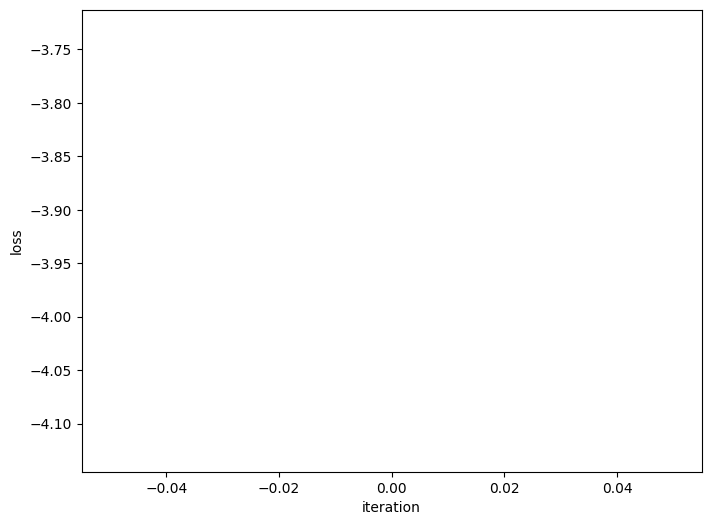

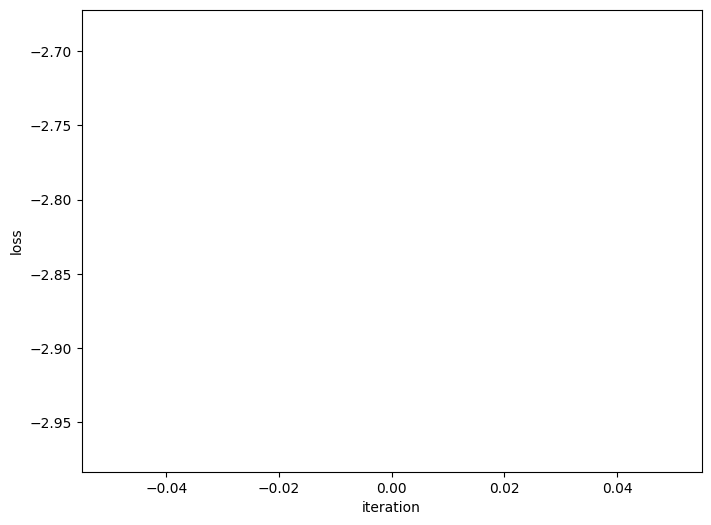

In [12]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [13]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()

weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -524.28210  validloss -543.85118±0.00000  bestvalidloss -543.85118  last_update 0
train: iter 1  trainloss -544.07303  validloss -498.99880±0.00000  bestvalidloss -543.85118  last_update 1
train: iter 2  trainloss -551.88246  validloss -527.61464±0.00000  bestvalidloss -543.85118  last_update 2
train: iter 3  trainloss -559.62510  validloss -540.44516±0.00000  bestvalidloss -543.85118  last_update 3
train: iter 4  trainloss -542.06860  validloss -497.88377±0.00000  bestvalidloss -543.85118  last_update 4
train: iter 5  trainloss -516.62708  validloss -485.07958±0.00000  bestvalidloss -543.85118  last_update 5
train: iter 6  trainloss -547.90964  validloss -519.77205±0.00000  bestvalidloss -543.85118  last_update 6
train: iter 7  trainloss -552.74286  validloss -449.29285±0.00000  bestvalidloss -543.85118  last_update 7
train: iter 8  trainloss -502.62159  validloss -523.79901±0.00000  bestvalidloss -543.85118  last_u

train: iter 76  trainloss -569.20128  validloss -540.87932±0.00000  bestvalidloss -556.08002  last_update 12
train: iter 77  trainloss -551.39595  validloss -531.36996±0.00000  bestvalidloss -556.08002  last_update 13
train: iter 78  trainloss -554.93200  validloss -497.54133±0.00000  bestvalidloss -556.08002  last_update 14
train: iter 79  trainloss -559.22681  validloss -554.35214±0.00000  bestvalidloss -556.08002  last_update 15
train: iter 80  trainloss -551.65557  validloss -483.59188±0.00000  bestvalidloss -556.08002  last_update 16
train: iter 81  trainloss -543.98683  validloss -541.64114±0.00000  bestvalidloss -556.08002  last_update 17
train: iter 82  trainloss -549.75933  validloss -470.94088±0.00000  bestvalidloss -556.08002  last_update 18
train: iter 83  trainloss -577.42306  validloss -504.35317±0.00000  bestvalidloss -556.08002  last_update 19
train: iter 84  trainloss -559.86160  validloss -521.31593±0.00000  bestvalidloss -556.08002  last_update 20
train: iter 85  tra

train: iter 151  trainloss -574.32286  validloss -531.98100±0.00000  bestvalidloss -562.90397  last_update 37
train: iter 152  trainloss -574.93275  validloss -529.41449±0.00000  bestvalidloss -562.90397  last_update 38
train: iter 153  trainloss -477.19616  validloss -536.65523±0.00000  bestvalidloss -562.90397  last_update 39
train: iter 154  trainloss -546.57624  validloss -473.22090±0.00000  bestvalidloss -562.90397  last_update 40
train: iter 155  trainloss -569.85816  validloss -531.86171±0.00000  bestvalidloss -562.90397  last_update 41
train: iter 156  trainloss -580.49759  validloss -557.28256±0.00000  bestvalidloss -562.90397  last_update 42
train: iter 157  trainloss -581.75821  validloss -554.07537±0.00000  bestvalidloss -562.90397  last_update 43
train: iter 158  trainloss -581.82822  validloss -558.44618±0.00000  bestvalidloss -562.90397  last_update 44
train: iter 159  trainloss -581.92032  validloss -557.69373±0.00000  bestvalidloss -562.90397  last_update 45
train: ite

train: iter 226  trainloss -569.98376  validloss -525.84971±0.00000  bestvalidloss -568.58963  last_update 43
train: iter 227  trainloss -523.19660  validloss -496.53085±0.00000  bestvalidloss -568.58963  last_update 44
train: iter 228  trainloss -574.74330  validloss -532.79078±0.00000  bestvalidloss -568.58963  last_update 45
train: iter 229  trainloss -582.15222  validloss -518.87082±0.00000  bestvalidloss -568.58963  last_update 46
train: iter 230  trainloss -583.61978  validloss -548.45801±0.00000  bestvalidloss -568.58963  last_update 47
train: iter 231  trainloss -576.72707  validloss -531.09371±0.00000  bestvalidloss -568.58963  last_update 48
train: iter 232  trainloss -502.43795  validloss -481.33428±0.00000  bestvalidloss -568.58963  last_update 49
train: iter 233  trainloss -560.90339  validloss -517.38037±0.00000  bestvalidloss -568.58963  last_update 50
train: iter 234  trainloss -575.44770  validloss -538.15435±0.00000  bestvalidloss -568.58963  last_update 51
train: ite

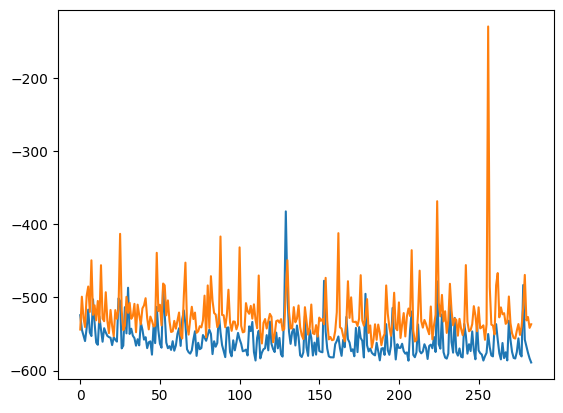

alpha 0.1 default_lr 0.0005


In [14]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()
    print("alpha",alpha, "default_lr", default_lr)

In [15]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [16]:
print(datetime.datetime.now())

2023-07-30 21:10:47.834726


# Iter2

In [17]:
policy_evaluation_iter=1

In [18]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [19]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.36160  validloss 0.72321±0.00000  bestvalidloss 0.72321  last_update 0
train: iter 1  trainloss 0.31990  validloss 0.40567±0.00000  bestvalidloss 0.40567  last_update 0
train: iter 2  trainloss 0.29905  validloss 0.39679±0.00000  bestvalidloss 0.39679  last_update 0
train: iter 3  trainloss 0.29391  validloss 0.38742±0.00000  bestvalidloss 0.38742  last_update 0
train: iter 4  trainloss 0.29222  validloss 0.37830±0.00000  bestvalidloss 0.37830  last_update 0
train: iter 5  trainloss 0.28629  validloss 0.36990±0.00000  bestvalidloss 0.36990  last_update 0
train: iter 6  trainloss 0.28569  validloss 0.37570±0.00000  bestvalidloss 0.36990  last_update 1
train: iter 7  trainloss 0.28243  validloss 0.36911±0.00000  bestvalidloss 0.36911  last_update 0
train: iter 8  trainloss 0.27975  validloss 0.36842±0.00000  bestvalidloss 0.36842  last_update 0
train: iter 9  trainloss 0.27747  validloss 0.36124±0.00000  bestvalidloss 0.36124  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.24954  validloss 0.34596±0.00000  bestvalidloss 0.33618  last_update 6
train: iter 84  trainloss 0.24903  validloss 0.33991±0.00000  bestvalidloss 0.33618  last_update 7
train: iter 85  trainloss 0.25005  validloss 0.34202±0.00000  bestvalidloss 0.33618  last_update 8
train: iter 86  trainloss 0.24863  validloss 0.34820±0.00000  bestvalidloss 0.33618  last_update 9
train: iter 87  trainloss 0.24946  validloss 0.34297±0.00000  bestvalidloss 0.33618  last_update 10
train: iter 88  trainloss 0.24792  validloss 0.34353±0.00000  bestvalidloss 0.33618  last_update 11
train: iter 89  trainloss 0.24855  validloss 0.33755±0.00000  bestvalidloss 0.33618  last_update 12
train: iter 90  trainloss 0.24860  validloss 0.35713±0.00000  bestvalidloss 0.33618  last_update 13
train: iter 91  trainloss 0.24904  validloss 0.35210±0.00000  bestvalidloss 0.33618  last_update 14
train: iter 92  trainloss 0.24795  validloss 0.33453±0.00000  bestvalidloss 0.33453  last_update 0
train

train: iter 166  trainloss 0.23847  validloss 0.34007±0.00000  bestvalidloss 0.33211  last_update 15
train: iter 167  trainloss 0.24157  validloss 0.34006±0.00000  bestvalidloss 0.33211  last_update 16
train: iter 168  trainloss 0.23957  validloss 0.33858±0.00000  bestvalidloss 0.33211  last_update 17
train: iter 169  trainloss 0.23989  validloss 0.33541±0.00000  bestvalidloss 0.33211  last_update 18
train: iter 170  trainloss 0.24243  validloss 0.34350±0.00000  bestvalidloss 0.33211  last_update 19
train: iter 171  trainloss 0.24069  validloss 0.33281±0.00000  bestvalidloss 0.33211  last_update 20
train: iter 172  trainloss 0.24041  validloss 0.33878±0.00000  bestvalidloss 0.33211  last_update 21
train: iter 173  trainloss 0.24071  validloss 0.34025±0.00000  bestvalidloss 0.33211  last_update 22
train: iter 174  trainloss 0.24150  validloss 0.33348±0.00000  bestvalidloss 0.33211  last_update 23
train: iter 175  trainloss 0.23938  validloss 0.33544±0.00000  bestvalidloss 0.33211  last_

train: iter 248  trainloss 0.23293  validloss 0.34163±0.00000  bestvalidloss 0.32924  last_update 48
train: iter 249  trainloss 0.23190  validloss 0.33450±0.00000  bestvalidloss 0.32924  last_update 49
train: iter 250  trainloss 0.23217  validloss 0.33145±0.00000  bestvalidloss 0.32924  last_update 50
train: iter 251  trainloss 0.22913  validloss 0.33989±0.00000  bestvalidloss 0.32924  last_update 51
train: iter 252  trainloss 0.23276  validloss 0.34122±0.00000  bestvalidloss 0.32924  last_update 52
train: iter 253  trainloss 0.23014  validloss 0.33655±0.00000  bestvalidloss 0.32924  last_update 53
train: iter 254  trainloss 0.23310  validloss 0.34147±0.00000  bestvalidloss 0.32924  last_update 54
train: iter 255  trainloss 0.23088  validloss 0.34080±0.00000  bestvalidloss 0.32924  last_update 55
train: iter 256  trainloss 0.23366  validloss 0.34536±0.00000  bestvalidloss 0.32924  last_update 56
train: iter 257  trainloss 0.23411  validloss 0.34192±0.00000  bestvalidloss 0.32924  last_

train_loss:  -4.138302442580461
valid_loss:  -8.802078086328505
weight_alpha 1.0 h_min_tilde -11.697878 ell_tilde -5.071057571330069 kappa_tilde 0.0003884609810300867
train_loss:  -3.0058547570228575
valid_loss:  -2.871843437767029
weight_alpha 0.1 h_min_tilde -11.697878 ell_tilde -2.9790524931716917 kappa_tilde 0.00033866554112220725


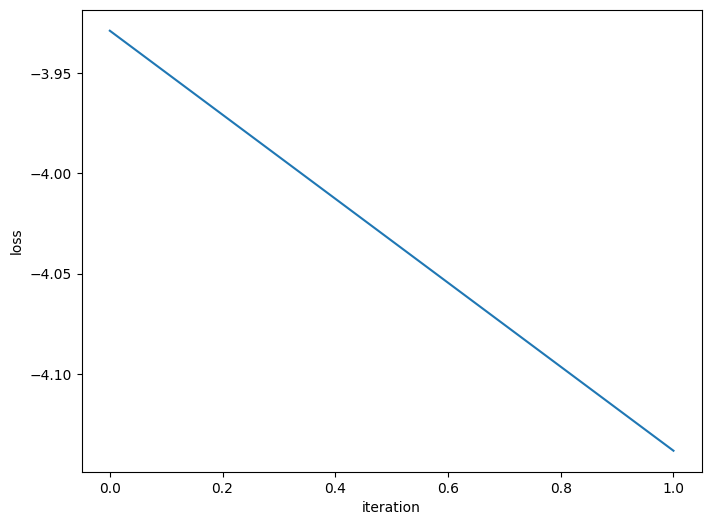

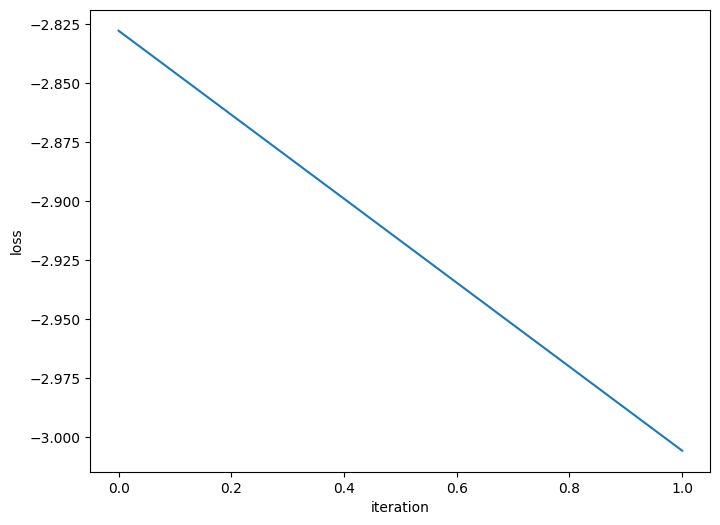

In [20]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [21]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -583.13695  validloss -574.11439±0.00000  bestvalidloss -574.11439  last_update 0
train: iter 1  trainloss -572.35581  validloss -531.95888±0.00000  bestvalidloss -574.11439  last_update 1
train: iter 2  trainloss -569.09880  validloss -565.34667±0.00000  bestvalidloss -574.11439  last_update 2
train: iter 3  trainloss -591.24508  validloss -559.90367±0.00000  bestvalidloss -574.11439  last_update 3
train: iter 4  trainloss -593.57508  validloss -579.91110±0.00000  bestvalidloss -579.91110  last_update 0
train: iter 5  trainloss -589.83632  validloss -566.95030±0.00000  bestvalidloss -579.91110  last_update 1
train: iter 6  trainloss -588.58493  validloss -584.36884±0.00000  bestvalidloss -584.36884  last_update 0
train: iter 7  trainloss -573.14787  validloss -575.49180±0.00000  bestvalidloss -584.36884  last_update 1
train: iter 8  trainloss -585.25950  validloss -546.23545±0.00000  bestvalidloss -584.36884  last_u

train: iter 76  trainloss -593.60190  validloss -565.68579±0.00000  bestvalidloss -586.53234  last_update 16
train: iter 77  trainloss -595.06410  validloss -578.91217±0.00000  bestvalidloss -586.53234  last_update 17
train: iter 78  trainloss -578.84624  validloss -554.17301±0.00000  bestvalidloss -586.53234  last_update 18
train: iter 79  trainloss -576.29004  validloss -565.21921±0.00000  bestvalidloss -586.53234  last_update 19
train: iter 80  trainloss -571.20546  validloss -557.32851±0.00000  bestvalidloss -586.53234  last_update 20
train: iter 81  trainloss -589.22308  validloss -555.47698±0.00000  bestvalidloss -586.53234  last_update 21
train: iter 82  trainloss -584.58661  validloss -570.12700±0.00000  bestvalidloss -586.53234  last_update 22
train: iter 83  trainloss -585.35894  validloss -554.73980±0.00000  bestvalidloss -586.53234  last_update 23
train: iter 84  trainloss -584.69403  validloss -560.91595±0.00000  bestvalidloss -586.53234  last_update 24
train: iter 85  tra

train: iter 151  trainloss -589.30897  validloss -544.18182±0.00000  bestvalidloss -586.53234  last_update 91
train: iter 152  trainloss -579.71850  validloss -539.33418±0.00000  bestvalidloss -586.53234  last_update 92
train: iter 153  trainloss -578.07864  validloss -550.40000±0.00000  bestvalidloss -586.53234  last_update 93
train: iter 154  trainloss -594.55949  validloss -558.36782±0.00000  bestvalidloss -586.53234  last_update 94
train: iter 155  trainloss -591.41488  validloss -561.78657±0.00000  bestvalidloss -586.53234  last_update 95
train: iter 156  trainloss -584.68596  validloss -566.68631±0.00000  bestvalidloss -586.53234  last_update 96
train: iter 157  trainloss -577.23859  validloss -490.78139±0.00000  bestvalidloss -586.53234  last_update 97
train: iter 158  trainloss -591.46127  validloss -569.78787±0.00000  bestvalidloss -586.53234  last_update 98
train: iter 159  trainloss -577.94605  validloss -557.99604±0.00000  bestvalidloss -586.53234  last_update 99
train: ite

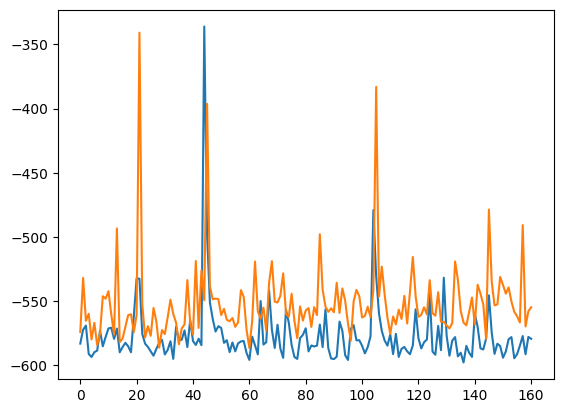

alpha 0.1 default_lr 0.0005


In [22]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()
print("alpha",alpha, "default_lr", default_lr)

In [23]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)


In [24]:
print(datetime.datetime.now())

2023-07-30 21:34:37.439056


In [25]:
# if policy_evaluation_iter<policy_evaluation_maxiter:
#     normalized_loss_array = np.array(normalized_loss_list)
#     plt.figure(figsize=(16,12))
#     plt.plot(normalized_loss_array[:,0])
#     plt.xlabel("iteration")
#     plt.ylabel("loss")


# Iter 3

In [26]:
policy_evaluation_iter=2

In [27]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85
predict diverge [-44.75847335 -20.99516796 -23.83026348  -8.00295033] [-0.78571909 -0.42584022 -0.43963635 -0.49346754] [123.31068   20.796759 186.59457   34.53283 ] [61.65534  10.398379 93.29729  17.266415] sim_timestep 160

 86

 87
predict diverge [-43.84321096 -20.99068821 -22.25799141 -10.28605094] [-0.80047007 -0.56947792 -0.53599741 -0.77616185] [123.31068   20.796759 186.59457   34.53283 ] [61.65534  10.398379 93.29729  17.266415] sim_timestep 186

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [28]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.33842  validloss 0.42574±0.00000  bestvalidloss 0.42574  last_update 0
train: iter 1  trainloss 0.31709  validloss 0.36043±0.00000  bestvalidloss 0.36043  last_update 0
train: iter 2  trainloss 0.31212  validloss 0.36249±0.00000  bestvalidloss 0.36043  last_update 1
train: iter 3  trainloss 0.30525  validloss 0.35403±0.00000  bestvalidloss 0.35403  last_update 0
train: iter 4  trainloss 0.30233  validloss 0.35777±0.00000  bestvalidloss 0.35403  last_update 1
train: iter 5  trainloss 0.30028  validloss 0.35365±0.00000  bestvalidloss 0.35365  last_update 0
train: iter 6  trainloss 0.30003  validloss 0.35251±0.00000  bestvalidloss 0.35251  last_update 0
train: iter 7  trainloss 0.29656  validloss 0.34656±0.00000  bestvalidloss 0.34656  last_update 0
train: iter 8  trainloss 0.29891  validloss 0.35334±0.00000  bestvalidloss 0.34656  last_update 1
train: iter 9  trainloss 0.29359  validloss 0.34885±0.00000  bestvalidloss 0.34656  last_update 2
train: iter 10  trai

train: iter 83  trainloss 0.24926  validloss 0.34860±0.00000  bestvalidloss 0.34073  last_update 6
train: iter 84  trainloss 0.25348  validloss 0.34233±0.00000  bestvalidloss 0.34073  last_update 7
train: iter 85  trainloss 0.25150  validloss 0.34314±0.00000  bestvalidloss 0.34073  last_update 8
train: iter 86  trainloss 0.24821  validloss 0.34574±0.00000  bestvalidloss 0.34073  last_update 9
train: iter 87  trainloss 0.24852  validloss 0.34760±0.00000  bestvalidloss 0.34073  last_update 10
train: iter 88  trainloss 0.24771  validloss 0.34150±0.00000  bestvalidloss 0.34073  last_update 11
train: iter 89  trainloss 0.24678  validloss 0.34272±0.00000  bestvalidloss 0.34073  last_update 12
train: iter 90  trainloss 0.24630  validloss 0.34332±0.00000  bestvalidloss 0.34073  last_update 13
train: iter 91  trainloss 0.24391  validloss 0.33923±0.00000  bestvalidloss 0.33923  last_update 0
train: iter 92  trainloss 0.24683  validloss 0.33929±0.00000  bestvalidloss 0.33923  last_update 1
train:

train: iter 165  trainloss 0.23645  validloss 0.33570±0.00000  bestvalidloss 0.33427  last_update 25
train: iter 166  trainloss 0.23190  validloss 0.34935±0.00000  bestvalidloss 0.33427  last_update 26
train: iter 167  trainloss 0.23508  validloss 0.34734±0.00000  bestvalidloss 0.33427  last_update 27
train: iter 168  trainloss 0.23526  validloss 0.35167±0.00000  bestvalidloss 0.33427  last_update 28
train: iter 169  trainloss 0.23459  validloss 0.34283±0.00000  bestvalidloss 0.33427  last_update 29
train: iter 170  trainloss 0.23296  validloss 0.34990±0.00000  bestvalidloss 0.33427  last_update 30
train: iter 171  trainloss 0.23827  validloss 0.34521±0.00000  bestvalidloss 0.33427  last_update 31
train: iter 172  trainloss 0.23531  validloss 0.34096±0.00000  bestvalidloss 0.33427  last_update 32
train: iter 173  trainloss 0.23436  validloss 0.34331±0.00000  bestvalidloss 0.33427  last_update 33
train: iter 174  trainloss 0.23385  validloss 0.34077±0.00000  bestvalidloss 0.33427  last_

train: iter 247  trainloss 0.22798  validloss 0.33738±0.00000  bestvalidloss 0.33260  last_update 37
train: iter 248  trainloss 0.23347  validloss 0.34135±0.00000  bestvalidloss 0.33260  last_update 38
train: iter 249  trainloss 0.22800  validloss 0.33774±0.00000  bestvalidloss 0.33260  last_update 39
train: iter 250  trainloss 0.22580  validloss 0.33983±0.00000  bestvalidloss 0.33260  last_update 40
train: iter 251  trainloss 0.22809  validloss 0.33475±0.00000  bestvalidloss 0.33260  last_update 41
train: iter 252  trainloss 0.22522  validloss 0.34111±0.00000  bestvalidloss 0.33260  last_update 42
train: iter 253  trainloss 0.22821  validloss 0.34080±0.00000  bestvalidloss 0.33260  last_update 43
train: iter 254  trainloss 0.22872  validloss 0.33248±0.00000  bestvalidloss 0.33248  last_update 0
train: iter 255  trainloss 0.22682  validloss 0.33303±0.00000  bestvalidloss 0.33248  last_update 1
train: iter 256  trainloss 0.22732  validloss 0.34193±0.00000  bestvalidloss 0.33248  last_up

train: iter 330  trainloss 0.22094  validloss 0.33606±0.00000  bestvalidloss 0.32940  last_update 17
train: iter 331  trainloss 0.22049  validloss 0.33360±0.00000  bestvalidloss 0.32940  last_update 18
train: iter 332  trainloss 0.21901  validloss 0.33891±0.00000  bestvalidloss 0.32940  last_update 19
train: iter 333  trainloss 0.22236  validloss 0.33688±0.00000  bestvalidloss 0.32940  last_update 20
train: iter 334  trainloss 0.22235  validloss 0.33312±0.00000  bestvalidloss 0.32940  last_update 21
train: iter 335  trainloss 0.22010  validloss 0.33156±0.00000  bestvalidloss 0.32940  last_update 22
train: iter 336  trainloss 0.21905  validloss 0.33335±0.00000  bestvalidloss 0.32940  last_update 23
train: iter 337  trainloss 0.22219  validloss 0.33422±0.00000  bestvalidloss 0.32940  last_update 24
train: iter 338  trainloss 0.22129  validloss 0.33394±0.00000  bestvalidloss 0.32940  last_update 25
train: iter 339  trainloss 0.22008  validloss 0.34213±0.00000  bestvalidloss 0.32940  last_

train: iter 413  trainloss 0.21459  validloss 0.33852±0.00000  bestvalidloss 0.32940  last_update 100
train: fin


train_loss:  -4.517843552082776
valid_loss:  -10.417166032934187
weight_alpha 1.0 h_min_tilde -11.538592 ell_tilde -5.697708048253059 kappa_tilde 0.00041377161892593633
train_loss:  -2.7439716511726386
valid_loss:  -2.621434367370605
weight_alpha 0.1 h_min_tilde -11.538592 ell_tilde -2.719464194412232 kappa_tilde 0.00033673415832587557


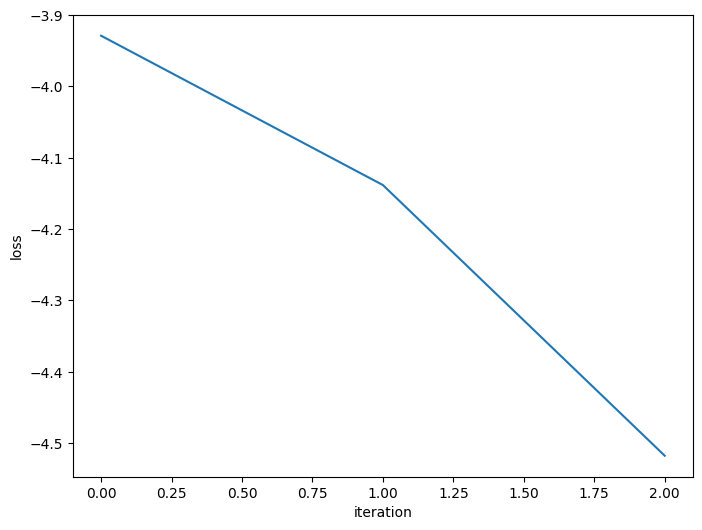

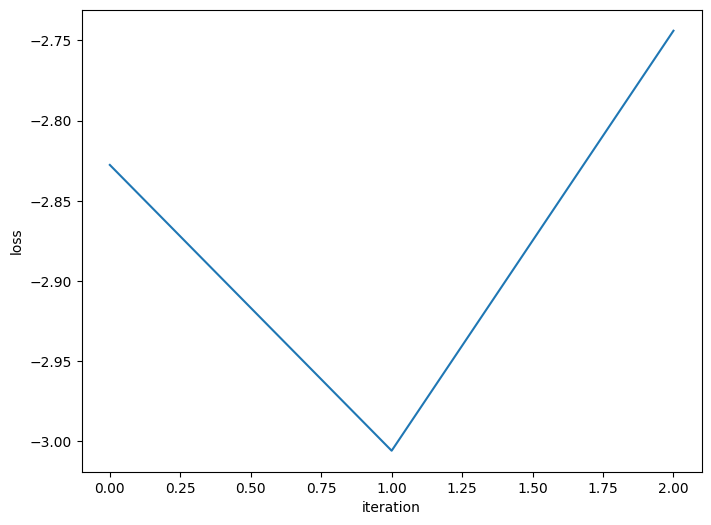

In [29]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")


In [30]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -541.43923  validloss -522.98644±0.00000  bestvalidloss -522.98644  last_update 0
train: iter 1  trainloss -512.61165  validloss -504.08755±0.00000  bestvalidloss -522.98644  last_update 1
train: iter 2  trainloss -553.93010  validloss -511.44089±0.00000  bestvalidloss -522.98644  last_update 2
train: iter 3  trainloss -534.37193  validloss -538.99881±0.00000  bestvalidloss -538.99881  last_update 0
train: iter 4  trainloss -556.33080  validloss -543.06480±0.00000  bestvalidloss -543.06480  last_update 0
train: iter 5  trainloss -567.70268  validloss -525.09941±0.00000  bestvalidloss -543.06480  last_update 1
train: iter 6  trainloss -569.07522  validloss -557.70978±0.00000  bestvalidloss -557.70978  last_update 0
train: iter 7  trainloss -552.37207  validloss -549.67591±0.00000  bestvalidloss -557.70978  last_update 1
train: iter 8  trainloss -547.67977  validloss -529.37782±0.00000  bestvalidloss -557.70978  last_u

train: iter 76  trainloss -560.01437  validloss -541.14248±0.00000  bestvalidloss -566.93244  last_update 26
train: iter 77  trainloss -556.05137  validloss -552.21462±0.00000  bestvalidloss -566.93244  last_update 27
train: iter 78  trainloss -553.20429  validloss -552.35098±0.00000  bestvalidloss -566.93244  last_update 28
train: iter 79  trainloss -556.84348  validloss -509.97236±0.00000  bestvalidloss -566.93244  last_update 29
train: iter 80  trainloss -550.23737  validloss -542.04016±0.00000  bestvalidloss -566.93244  last_update 30
train: iter 81  trainloss -547.71826  validloss -521.46515±0.00000  bestvalidloss -566.93244  last_update 31
train: iter 82  trainloss -532.31461  validloss -398.68297±0.00000  bestvalidloss -566.93244  last_update 32
train: iter 83  trainloss -567.06681  validloss -540.64512±0.00000  bestvalidloss -566.93244  last_update 33
train: iter 84  trainloss -571.43854  validloss -547.91282±0.00000  bestvalidloss -566.93244  last_update 34
train: iter 85  tra

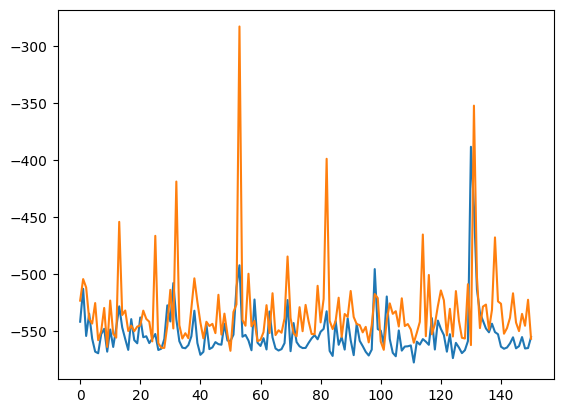

alpha 0.1 default_lr 0.0005


In [31]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [32]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [33]:
print(datetime.datetime.now())

2023-07-30 21:59:26.604215


# Iter 4

In [34]:
policy_evaluation_iter=3

In [35]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [36]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.27153  validloss 0.39401±0.00000  bestvalidloss 0.39401  last_update 0
train: iter 1  trainloss 0.25849  validloss 0.34334±0.00000  bestvalidloss 0.34334  last_update 0
train: iter 2  trainloss 0.25467  validloss 0.34083±0.00000  bestvalidloss 0.34083  last_update 0
train: iter 3  trainloss 0.25167  validloss 0.34361±0.00000  bestvalidloss 0.34083  last_update 1
train: iter 4  trainloss 0.25188  validloss 0.34074±0.00000  bestvalidloss 0.34074  last_update 0
train: iter 5  trainloss 0.24895  validloss 0.33908±0.00000  bestvalidloss 0.33908  last_update 0
train: iter 6  trainloss 0.24515  validloss 0.34067±0.00000  bestvalidloss 0.33908  last_update 1
train: iter 7  trainloss 0.24676  validloss 0.34423±0.00000  bestvalidloss 0.33908  last_update 2
train: iter 8  trainloss 0.24874  validloss 0.33959±0.00000  bestvalidloss 0.33908  last_update 3
train: iter 9  trainloss 0.24409  validloss 0.34021±0.00000  bestvalidloss 0.33908  last_update 4
train: iter 10  trai

train: iter 83  trainloss 0.22548  validloss 0.32826±0.00000  bestvalidloss 0.32430  last_update 20
train: iter 84  trainloss 0.22631  validloss 0.33074±0.00000  bestvalidloss 0.32430  last_update 21
train: iter 85  trainloss 0.22241  validloss 0.32932±0.00000  bestvalidloss 0.32430  last_update 22
train: iter 86  trainloss 0.22419  validloss 0.32722±0.00000  bestvalidloss 0.32430  last_update 23
train: iter 87  trainloss 0.22487  validloss 0.32627±0.00000  bestvalidloss 0.32430  last_update 24
train: iter 88  trainloss 0.22485  validloss 0.32479±0.00000  bestvalidloss 0.32430  last_update 25
train: iter 89  trainloss 0.22245  validloss 0.32830±0.00000  bestvalidloss 0.32430  last_update 26
train: iter 90  trainloss 0.22351  validloss 0.32723±0.00000  bestvalidloss 0.32430  last_update 27
train: iter 91  trainloss 0.22490  validloss 0.34610±0.00000  bestvalidloss 0.32430  last_update 28
train: iter 92  trainloss 0.22301  validloss 0.33015±0.00000  bestvalidloss 0.32430  last_update 29


train: iter 166  trainloss 0.21302  validloss 0.34527±0.00000  bestvalidloss 0.32265  last_update 40
train: iter 167  trainloss 0.21411  validloss 0.33553±0.00000  bestvalidloss 0.32265  last_update 41
train: iter 168  trainloss 0.21363  validloss 0.32832±0.00000  bestvalidloss 0.32265  last_update 42
train: iter 169  trainloss 0.21408  validloss 0.32839±0.00000  bestvalidloss 0.32265  last_update 43
train: iter 170  trainloss 0.21594  validloss 0.32747±0.00000  bestvalidloss 0.32265  last_update 44
train: iter 171  trainloss 0.21250  validloss 0.32549±0.00000  bestvalidloss 0.32265  last_update 45
train: iter 172  trainloss 0.21251  validloss 0.33150±0.00000  bestvalidloss 0.32265  last_update 46
train: iter 173  trainloss 0.21253  validloss 0.33487±0.00000  bestvalidloss 0.32265  last_update 47
train: iter 174  trainloss 0.21198  validloss 0.32971±0.00000  bestvalidloss 0.32265  last_update 48
train: iter 175  trainloss 0.21144  validloss 0.32573±0.00000  bestvalidloss 0.32265  last_

train_loss:  -5.1556720901936295
valid_loss:  -10.920447912633419
weight_alpha 1.0 h_min_tilde -11.764546 ell_tilde -6.308627254681587 kappa_tilde 0.00042812051326116045
train_loss:  -2.7974411524295806
valid_loss:  -2.566520346069336
weight_alpha 0.1 h_min_tilde -11.764546 ell_tilde -2.7512569911575313 kappa_tilde 0.00033308750548289185


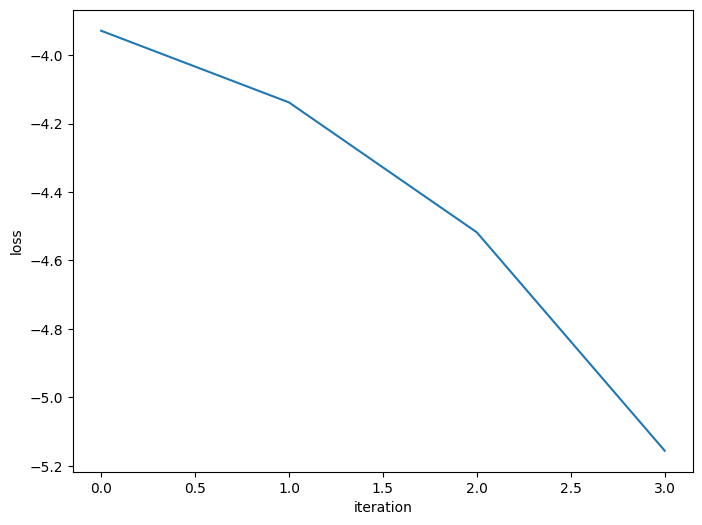

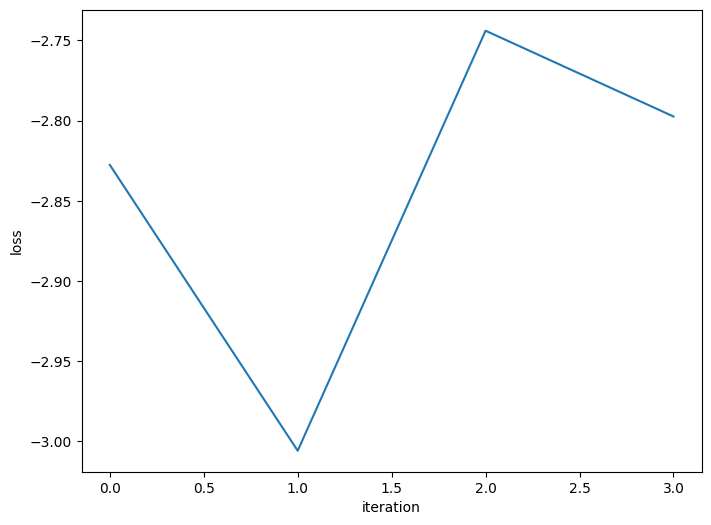

In [37]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [38]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -566.96164  validloss -516.12540±0.00000  bestvalidloss -516.12540  last_update 0
train: iter 1  trainloss -565.91933  validloss -556.35777±0.00000  bestvalidloss -556.35777  last_update 0
train: iter 2  trainloss -541.96039  validloss -543.82923±0.00000  bestvalidloss -556.35777  last_update 1
train: iter 3  trainloss -576.57171  validloss -533.61864±0.00000  bestvalidloss -556.35777  last_update 2
train: iter 4  trainloss -580.91432  validloss -574.36815±0.00000  bestvalidloss -574.36815  last_update 0
train: iter 5  trainloss -547.82951  validloss -510.42004±0.00000  bestvalidloss -574.36815  last_update 1
train: iter 6  trainloss -549.23838  validloss -529.37105±0.00000  bestvalidloss -574.36815  last_update 2
train: iter 7  trainloss -575.06988  validloss -556.15014±0.00000  bestvalidloss -574.36815  last_update 3
train: iter 8  trainloss -575.02941  validloss -561.92752±0.00000  bestvalidloss -574.36815  last_u

train: iter 75  trainloss -587.33428  validloss -554.83054±0.00000  bestvalidloss -574.36815  last_update 71
train: iter 76  trainloss -585.03034  validloss -538.73973±0.00000  bestvalidloss -574.36815  last_update 72
train: iter 77  trainloss -584.61611  validloss -559.40053±0.00000  bestvalidloss -574.36815  last_update 73
train: iter 78  trainloss -559.09912  validloss -536.11859±0.00000  bestvalidloss -574.36815  last_update 74
train: iter 79  trainloss -577.62687  validloss -559.20970±0.00000  bestvalidloss -574.36815  last_update 75
train: iter 80  trainloss -587.40874  validloss -557.83590±0.00000  bestvalidloss -574.36815  last_update 76
train: iter 81  trainloss -576.98072  validloss -544.75616±0.00000  bestvalidloss -574.36815  last_update 77
train: iter 82  trainloss -576.17200  validloss -545.99239±0.00000  bestvalidloss -574.36815  last_update 78
train: iter 83  trainloss -585.40868  validloss -530.52611±0.00000  bestvalidloss -574.36815  last_update 79
train: iter 84  tra

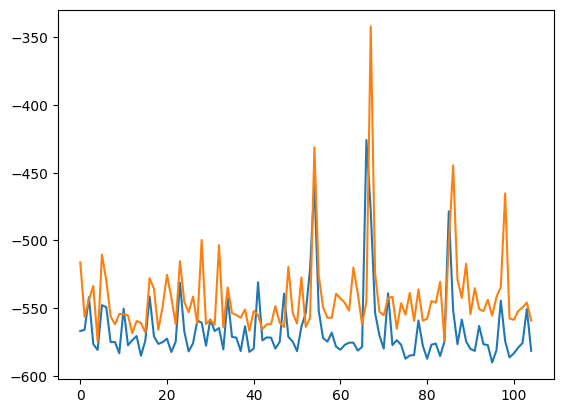

alpha 0.1 default_lr 0.0005


In [39]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [40]:
print(datetime.datetime.now())

2023-07-30 22:23:02.480045


# Iter 5

In [41]:
policy_evaluation_iter=4

In [42]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [43]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.31864  validloss 0.34401±0.00000  bestvalidloss 0.34401  last_update 0
train: iter 1  trainloss 0.28935  validloss 0.34021±0.00000  bestvalidloss 0.34021  last_update 0
train: iter 2  trainloss 0.27797  validloss 0.33769±0.00000  bestvalidloss 0.33769  last_update 0
train: iter 3  trainloss 0.27419  validloss 0.33591±0.00000  bestvalidloss 0.33591  last_update 0
train: iter 4  trainloss 0.26781  validloss 0.33146±0.00000  bestvalidloss 0.33146  last_update 0
train: iter 5  trainloss 0.26539  validloss 0.33257±0.00000  bestvalidloss 0.33146  last_update 1
train: iter 6  trainloss 0.26179  validloss 0.32827±0.00000  bestvalidloss 0.32827  last_update 0
train: iter 7  trainloss 0.25892  validloss 0.32688±0.00000  bestvalidloss 0.32688  last_update 0
train: iter 8  trainloss 0.25799  validloss 0.32998±0.00000  bestvalidloss 0.32688  last_update 1
train: iter 9  trainloss 0.25304  validloss 0.32615±0.00000  bestvalidloss 0.32615  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.22796  validloss 0.32402±0.00000  bestvalidloss 0.32064  last_update 66
train: iter 84  trainloss 0.22662  validloss 0.32346±0.00000  bestvalidloss 0.32064  last_update 67
train: iter 85  trainloss 0.22671  validloss 0.32947±0.00000  bestvalidloss 0.32064  last_update 68
train: iter 86  trainloss 0.22639  validloss 0.33067±0.00000  bestvalidloss 0.32064  last_update 69
train: iter 87  trainloss 0.22397  validloss 0.32488±0.00000  bestvalidloss 0.32064  last_update 70
train: iter 88  trainloss 0.22551  validloss 0.32868±0.00000  bestvalidloss 0.32064  last_update 71
train: iter 89  trainloss 0.22543  validloss 0.32877±0.00000  bestvalidloss 0.32064  last_update 72
train: iter 90  trainloss 0.22632  validloss 0.32552±0.00000  bestvalidloss 0.32064  last_update 73
train: iter 91  trainloss 0.22452  validloss 0.32232±0.00000  bestvalidloss 0.32064  last_update 74
train: iter 92  trainloss 0.22454  validloss 0.32734±0.00000  bestvalidloss 0.32064  last_update 75


train_loss:  -5.3073247084409
valid_loss:  -11.531235819125175
weight_alpha 1.0 h_min_tilde -11.813213 ell_tilde -6.5521069305777555 kappa_tilde 0.00043597486991199237
train_loss:  -3.201096576881408
valid_loss:  -2.9752199993133543
weight_alpha 0.1 h_min_tilde -11.813213 ell_tilde -3.155921261367797 kappa_tilde 0.00033986697401681385


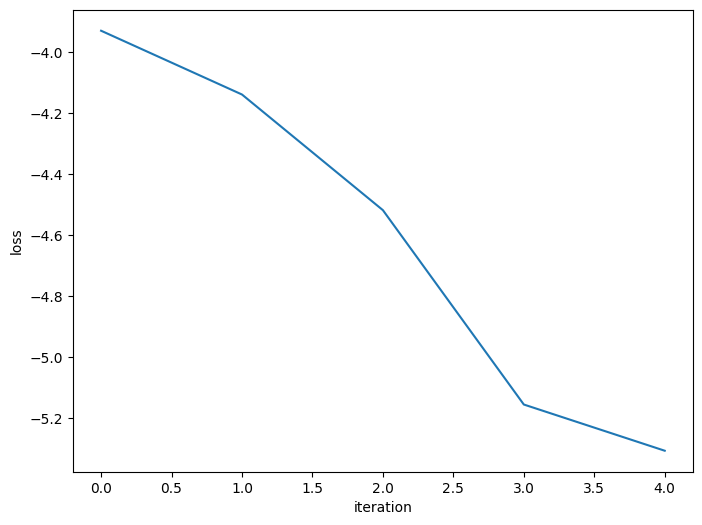

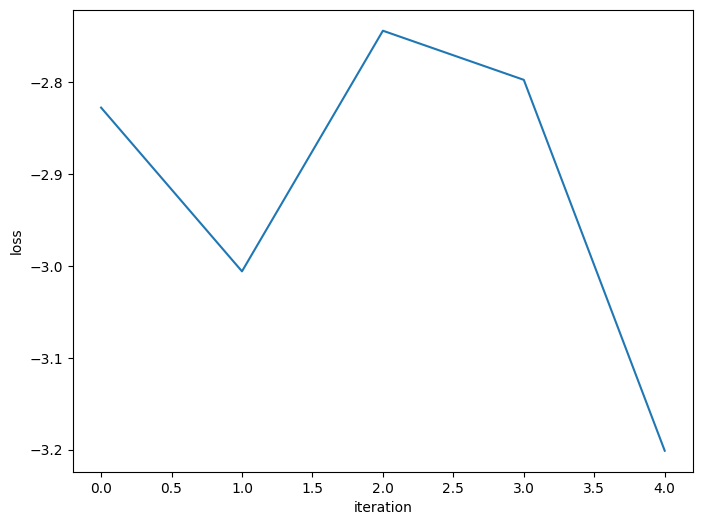

In [44]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [45]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -622.39740  validloss -598.02325±0.00000  bestvalidloss -598.02325  last_update 0
train: iter 1  trainloss -644.32640  validloss -588.18339±0.00000  bestvalidloss -598.02325  last_update 1
train: iter 2  trainloss -637.20473  validloss -623.84208±0.00000  bestvalidloss -623.84208  last_update 0
train: iter 3  trainloss -613.31731  validloss -582.37965±0.00000  bestvalidloss -623.84208  last_update 1
train: iter 4  trainloss -630.83104  validloss -583.16731±0.00000  bestvalidloss -623.84208  last_update 2
train: iter 5  trainloss -631.20942  validloss -609.16024±0.00000  bestvalidloss -623.84208  last_update 3
train: iter 6  trainloss -621.94735  validloss -603.31178±0.00000  bestvalidloss -623.84208  last_update 4
train: iter 7  trainloss -638.45880  validloss -590.49918±0.00000  bestvalidloss -623.84208  last_update 5
train: iter 8  trainloss -594.47564  validloss -609.78925±0.00000  bestvalidloss -623.84208  last_u

train: iter 76  trainloss -645.39156  validloss -605.40344±0.00000  bestvalidloss -631.24686  last_update 28
train: iter 77  trainloss -643.54641  validloss -589.45565±0.00000  bestvalidloss -631.24686  last_update 29
train: iter 78  trainloss -638.74736  validloss -603.43579±0.00000  bestvalidloss -631.24686  last_update 30
train: iter 79  trainloss -626.97090  validloss -598.68395±0.00000  bestvalidloss -631.24686  last_update 31
train: iter 80  trainloss -634.93651  validloss -573.29697±0.00000  bestvalidloss -631.24686  last_update 32
train: iter 81  trainloss -650.29583  validloss -631.33571±0.00000  bestvalidloss -631.33571  last_update 0
train: iter 82  trainloss -616.81846  validloss -611.83370±0.00000  bestvalidloss -631.33571  last_update 1
train: iter 83  trainloss -645.76643  validloss -609.33823±0.00000  bestvalidloss -631.33571  last_update 2
train: iter 84  trainloss -631.80527  validloss -591.19823±0.00000  bestvalidloss -631.33571  last_update 3
train: iter 85  trainlo

train: iter 151  trainloss -629.80654  validloss -613.15931±0.00000  bestvalidloss -634.86687  last_update 35
train: iter 152  trainloss -646.77276  validloss -607.67647±0.00000  bestvalidloss -634.86687  last_update 36
train: iter 153  trainloss -599.37631  validloss -574.98184±0.00000  bestvalidloss -634.86687  last_update 37
train: iter 154  trainloss -630.72765  validloss -586.50851±0.00000  bestvalidloss -634.86687  last_update 38
train: iter 155  trainloss -644.15187  validloss -609.47040±0.00000  bestvalidloss -634.86687  last_update 39
train: iter 156  trainloss -645.98755  validloss -598.65206±0.00000  bestvalidloss -634.86687  last_update 40
train: iter 157  trainloss -644.98528  validloss -603.75999±0.00000  bestvalidloss -634.86687  last_update 41
train: iter 158  trainloss -634.98206  validloss -621.24877±0.00000  bestvalidloss -634.86687  last_update 42
train: iter 159  trainloss -640.89696  validloss -563.09067±0.00000  bestvalidloss -634.86687  last_update 43
train: ite

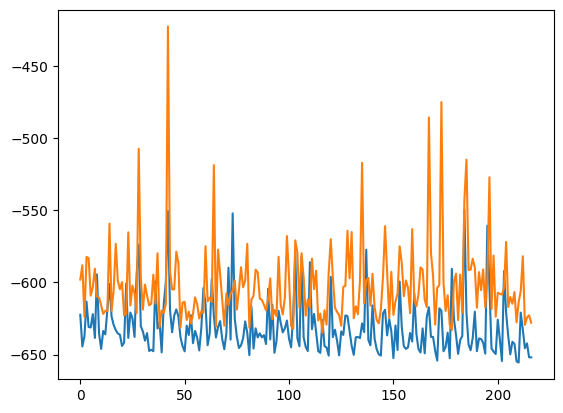

alpha 0.1 default_lr 0.0005


In [46]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [47]:
print(datetime.datetime.now())

2023-07-30 22:47:35.989615


# 評価関数計算

In [48]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7
predict diverge [-33.83584836   3.32877005  -7.79090283 -52.0227057 ] [  0.10859022   1.22559374  -0.90813019 -34.68422653] [123.31068   20.796759 186.59457   34.53283 ] [61.65534  10.398379 93.29729  17.266415] sim_timestep 194

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32
predict diverge [-36.70610849 -18.40282774 -22.79950513 -47.43275261] [ -0.57706167  -6.21223047  -1.32837365 -20.90926523] [123.31068   20.796759 186.59457   34.53283 ] [61.65534  10.398379 93.29729  17.266415] sim_timestep 113

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [49]:
iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.27442  validloss 0.43681±0.00000  bestvalidloss 0.43681  last_update 0
train: iter 1  trainloss 0.26596  validloss 0.39523±0.00000  bestvalidloss 0.39523  last_update 0
train: iter 2  trainloss 0.25969  validloss 0.39845±0.00000  bestvalidloss 0.39523  last_update 1
train: iter 3  trainloss 0.25798  validloss 0.40174±0.00000  bestvalidloss 0.39523  last_update 2
train: iter 4  trainloss 0.25418  validloss 0.40549±0.00000  bestvalidloss 0.39523  last_update 3
train: iter 5  trainloss 0.25296  validloss 0.39772±0.00000  bestvalidloss 0.39523  last_update 4
train: iter 6  trainloss 0.25133  validloss 0.40812±0.00000  bestvalidloss 0.39523  last_update 5
train: iter 7  trainloss 0.24892  validloss 0.40192±0.00000  bestvalidloss 0.39523  last_update 6
train: iter 8  trainloss 0.25078  validloss 0.40716±0.00000  bestvalidloss 0.39523  last_update 7
train: iter 9  trainloss 0.24625  validloss 0.39773±0.00000  bestvalidloss 0.39523  last_update 8
train: iter 10  trai

train: iter 83  trainloss 0.22547  validloss 0.42229±0.00000  bestvalidloss 0.38014  last_update 43
train: iter 84  trainloss 0.22543  validloss 0.41025±0.00000  bestvalidloss 0.38014  last_update 44
train: iter 85  trainloss 0.22483  validloss 0.40397±0.00000  bestvalidloss 0.38014  last_update 45
train: iter 86  trainloss 0.22280  validloss 0.41903±0.00000  bestvalidloss 0.38014  last_update 46
train: iter 87  trainloss 0.22366  validloss 0.40427±0.00000  bestvalidloss 0.38014  last_update 47
train: iter 88  trainloss 0.22263  validloss 0.40693±0.00000  bestvalidloss 0.38014  last_update 48
train: iter 89  trainloss 0.22364  validloss 0.40274±0.00000  bestvalidloss 0.38014  last_update 49
train: iter 90  trainloss 0.22313  validloss 0.41828±0.00000  bestvalidloss 0.38014  last_update 50
train: iter 91  trainloss 0.22183  validloss 0.42003±0.00000  bestvalidloss 0.38014  last_update 51
train: iter 92  trainloss 0.22174  validloss 0.40594±0.00000  bestvalidloss 0.38014  last_update 52


([0.27441557543352246,
  0.26595854237675665,
  0.2596918664872646,
  0.2579827600158751,
  0.2541810180991888,
  0.25296097807586193,
  0.2513328559696674,
  0.2489200146868825,
  0.25078199664130807,
  0.246253695897758,
  0.2481656005140394,
  0.2470227531157434,
  0.24487556302919983,
  0.24476303262636065,
  0.24298150432296098,
  0.2449517690576613,
  0.24575985837727785,
  0.24220052920281887,
  0.24275642801076175,
  0.2389964720234275,
  0.24204741679131986,
  0.2410732438787818,
  0.24019235959276558,
  0.23793547675013543,
  0.23842816269025208,
  0.23760523558594288,
  0.23781245392747224,
  0.23745690686628224,
  0.24114659773185848,
  0.23794049848802387,
  0.23860741630196572,
  0.23523216852918266,
  0.23623820091597736,
  0.234663291182369,
  0.23602868169546126,
  0.23591800555586814,
  0.23483937298879026,
  0.23516993625089527,
  0.23397442204877733,
  0.2326320292428136,
  0.23483148836530746,
  0.2338696772698313,
  0.23283997885882854,
  0.2322306149173528,
  0.2

In [50]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -4.814666697198153
valid_loss:  -12.10125861301422
weight_alpha 1.0 h_min_tilde -11.822648 ell_tilde -6.271985080361366 kappa_tilde 0.0004244510096130793
train_loss:  -3.0226306665420535
valid_loss:  -2.924143969345093
weight_alpha 0.1 h_min_tilde -11.822648 ell_tilde -3.002933327102661 kappa_tilde 0.00033672296046671155


In [51]:
train_curve, valid_curve = iwvi.train_initial_belief(num_iter=100000, lr=1e-3, early_stop_step=default_early)


train: iter 0  trainloss 28.95531  validloss 36.25138±0.00000  bestvalidloss 36.25138  last_update 0
train: iter 1  trainloss 20.43461  validloss 25.12823±0.00000  bestvalidloss 25.12823  last_update 0
train: iter 2  trainloss 13.70804  validloss 17.40643±0.00000  bestvalidloss 17.40643  last_update 0
train: iter 3  trainloss 9.84796  validloss 12.40164±0.00000  bestvalidloss 12.40164  last_update 0
train: iter 4  trainloss 6.66846  validloss 8.46973±0.00000  bestvalidloss 8.46973  last_update 0
train: iter 5  trainloss 4.47824  validloss 5.39995±0.00000  bestvalidloss 5.39995  last_update 0
train: iter 6  trainloss 2.91002  validloss 3.55111±0.00000  bestvalidloss 3.55111  last_update 0
train: iter 7  trainloss 1.93538  validloss 2.32334±0.00000  bestvalidloss 2.32334  last_update 0
train: iter 8  trainloss 1.11521  validloss 1.18815±0.00000  bestvalidloss 1.18815  last_update 0
train: iter 9  trainloss 0.74148  validloss 0.71441±0.00000  bestvalidloss 0.71441  last_update 0
train: it

train: iter 89  trainloss -1.39713  validloss -1.79304±0.00000  bestvalidloss -1.79304  last_update 0
train: iter 90  trainloss -1.42884  validloss -1.68661±0.00000  bestvalidloss -1.79304  last_update 1
train: iter 91  trainloss -1.41188  validloss -1.70508±0.00000  bestvalidloss -1.79304  last_update 2
train: iter 92  trainloss -1.46583  validloss -1.65352±0.00000  bestvalidloss -1.79304  last_update 3
train: iter 93  trainloss -1.47082  validloss -1.67822±0.00000  bestvalidloss -1.79304  last_update 4
train: iter 94  trainloss -1.45817  validloss -1.72440±0.00000  bestvalidloss -1.79304  last_update 5
train: iter 95  trainloss -1.50080  validloss -1.70659±0.00000  bestvalidloss -1.79304  last_update 6
train: iter 96  trainloss -1.45755  validloss -1.71446±0.00000  bestvalidloss -1.79304  last_update 7
train: iter 97  trainloss -1.44497  validloss -1.69972±0.00000  bestvalidloss -1.79304  last_update 8
train: iter 98  trainloss -1.45731  validloss -1.76997±0.00000  bestvalidloss -1.7

train: iter 174  trainloss -1.44295  validloss -1.67950±0.00000  bestvalidloss -1.81423  last_update 32
train: iter 175  trainloss -1.48040  validloss -1.74204±0.00000  bestvalidloss -1.81423  last_update 33
train: iter 176  trainloss -1.42873  validloss -1.76107±0.00000  bestvalidloss -1.81423  last_update 34
train: iter 177  trainloss -1.45216  validloss -1.64677±0.00000  bestvalidloss -1.81423  last_update 35
train: iter 178  trainloss -1.41613  validloss -1.66976±0.00000  bestvalidloss -1.81423  last_update 36
train: iter 179  trainloss -1.48147  validloss -1.68524±0.00000  bestvalidloss -1.81423  last_update 37
train: iter 180  trainloss -1.45686  validloss -1.69005±0.00000  bestvalidloss -1.81423  last_update 38
train: iter 181  trainloss -1.44337  validloss -1.66652±0.00000  bestvalidloss -1.81423  last_update 39
train: iter 182  trainloss -1.47848  validloss -1.69976±0.00000  bestvalidloss -1.81423  last_update 40
train: iter 183  trainloss -1.37174  validloss -1.64598±0.00000 

train: iter 254  trainloss -1.43551  validloss -1.70765±0.00000  bestvalidloss -1.83255  last_update 16
train: iter 255  trainloss -1.40097  validloss -1.72482±0.00000  bestvalidloss -1.83255  last_update 17
train: iter 256  trainloss -1.42389  validloss -1.74149±0.00000  bestvalidloss -1.83255  last_update 18
train: iter 257  trainloss -1.45006  validloss -1.74658±0.00000  bestvalidloss -1.83255  last_update 19
train: iter 258  trainloss -1.40631  validloss -1.65815±0.00000  bestvalidloss -1.83255  last_update 20
train: iter 259  trainloss -1.40630  validloss -1.72694±0.00000  bestvalidloss -1.83255  last_update 21
train: iter 260  trainloss -1.41750  validloss -1.74129±0.00000  bestvalidloss -1.83255  last_update 22
train: iter 261  trainloss -1.45902  validloss -1.81836±0.00000  bestvalidloss -1.83255  last_update 23
train: iter 262  trainloss -1.47426  validloss -1.78431±0.00000  bestvalidloss -1.83255  last_update 24
train: iter 263  trainloss -1.43209  validloss -1.72712±0.00000 

In [52]:
print(iwvi.initial_belief)


Parameter containing:
tensor([ 1.6706,  0.9795, -4.5348, -4.0320], requires_grad=True)


In [53]:
train_curve, valid_curve = iwvi.train_penalty(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early)

train: iter 0  trainloss 4.06816  validloss 7.42732±0.00000  bestvalidloss 7.42732  last_update 0
train: iter 1  trainloss 3.94546  validloss 8.27522±0.00000  bestvalidloss 7.42732  last_update 1
train: iter 2  trainloss 3.95421  validloss 7.38666±0.00000  bestvalidloss 7.38666  last_update 0
train: iter 3  trainloss 3.95817  validloss 7.34249±0.00000  bestvalidloss 7.34249  last_update 0
train: iter 4  trainloss 3.95362  validloss 7.63351±0.00000  bestvalidloss 7.34249  last_update 1
train: iter 5  trainloss 3.90890  validloss 7.29546±0.00000  bestvalidloss 7.29546  last_update 0
train: iter 6  trainloss 3.99757  validloss 7.54896±0.00000  bestvalidloss 7.29546  last_update 1
train: iter 7  trainloss 3.91252  validloss 7.64313±0.00000  bestvalidloss 7.29546  last_update 2
train: iter 8  trainloss 3.93392  validloss 7.12003±0.00000  bestvalidloss 7.12003  last_update 0
train: iter 9  trainloss 4.00245  validloss 6.90947±0.00000  bestvalidloss 6.90947  last_update 0
train: iter 10  trai

train: iter 84  trainloss 3.78449  validloss 7.31327±0.00000  bestvalidloss 6.68789  last_update 60
train: iter 85  trainloss 3.83202  validloss 7.99409±0.00000  bestvalidloss 6.68789  last_update 61
train: iter 86  trainloss 3.85302  validloss 7.68204±0.00000  bestvalidloss 6.68789  last_update 62
train: iter 87  trainloss 3.78821  validloss 6.87126±0.00000  bestvalidloss 6.68789  last_update 63
train: iter 88  trainloss 3.73566  validloss 7.05038±0.00000  bestvalidloss 6.68789  last_update 64
train: iter 89  trainloss 3.74601  validloss 7.07241±0.00000  bestvalidloss 6.68789  last_update 65
train: iter 90  trainloss 3.76929  validloss 7.13813±0.00000  bestvalidloss 6.68789  last_update 66
train: iter 91  trainloss 3.76271  validloss 7.51704±0.00000  bestvalidloss 6.68789  last_update 67
train: iter 92  trainloss 3.84839  validloss 7.16301±0.00000  bestvalidloss 6.68789  last_update 68
train: iter 93  trainloss 3.76563  validloss 7.51817±0.00000  bestvalidloss 6.68789  last_update 69


In [54]:
iwvi.save(ckpt_key="policy_optimization_iter1")

iwvi save ckpt1, ckpt2 ckpt_iwvi_basepartcartpole_policy_optimization_iter1 ckpt_iwvi_cartpole_policy_optimization_iter1
base save ckpt ckpt_basevi_cartpole_policy_optimization_iter1
base load self.initial_belief.data.sum() tensor(-5.9166)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(-18.3117)


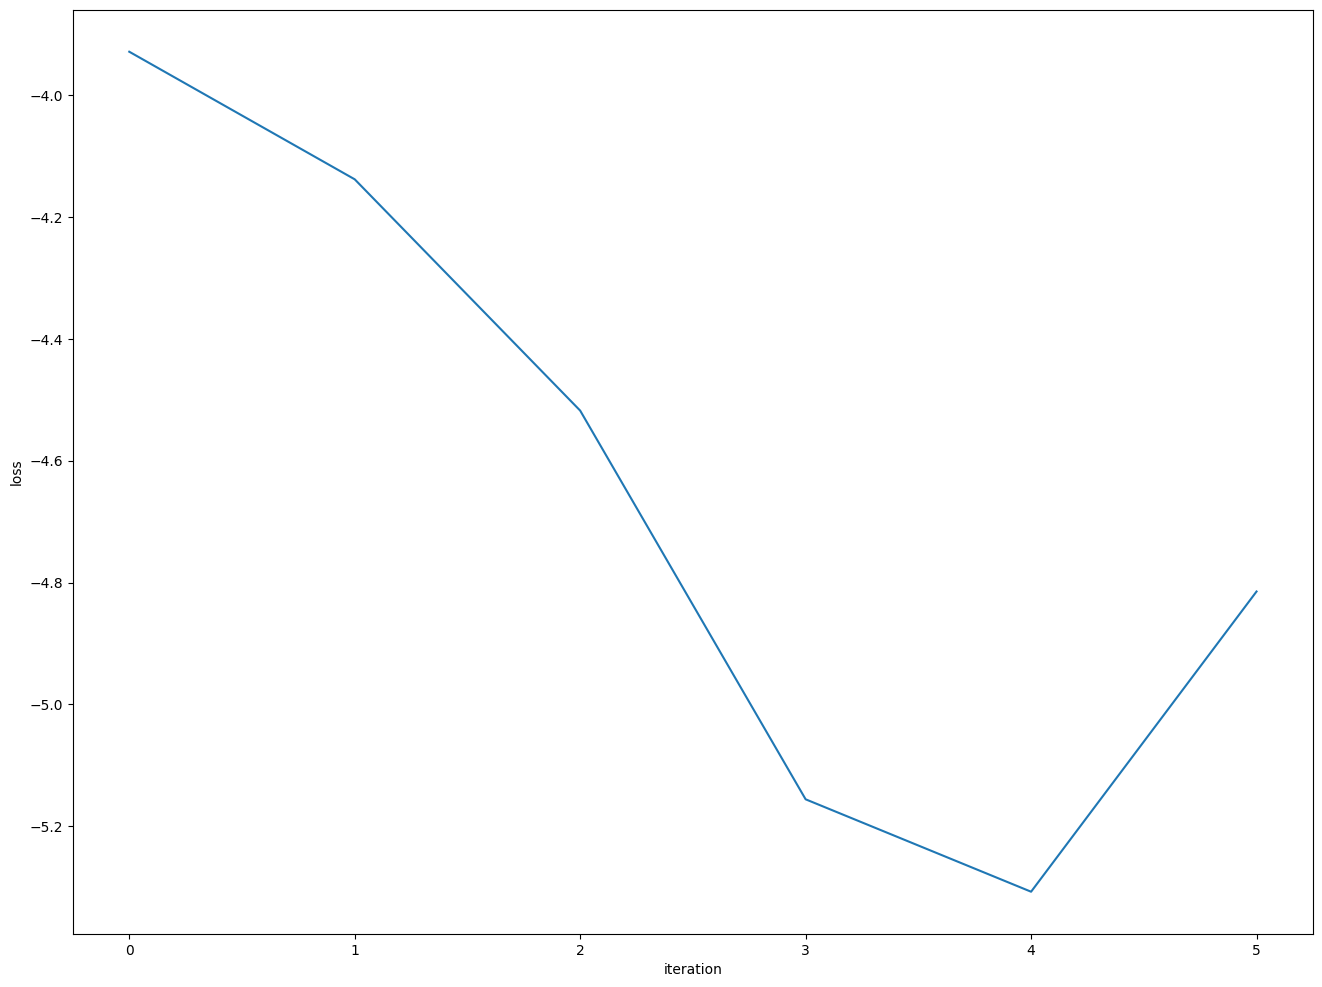

In [55]:
loss_array = np.array(loss_list)
plt.figure(figsize=(16,12))
plt.plot(loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve.png")
plt.savefig(figfilenamehead+"learning_curve.eps")
# plt.savefig(figfilenamehead+"policy_evaluartion_learning_curve.pdf")

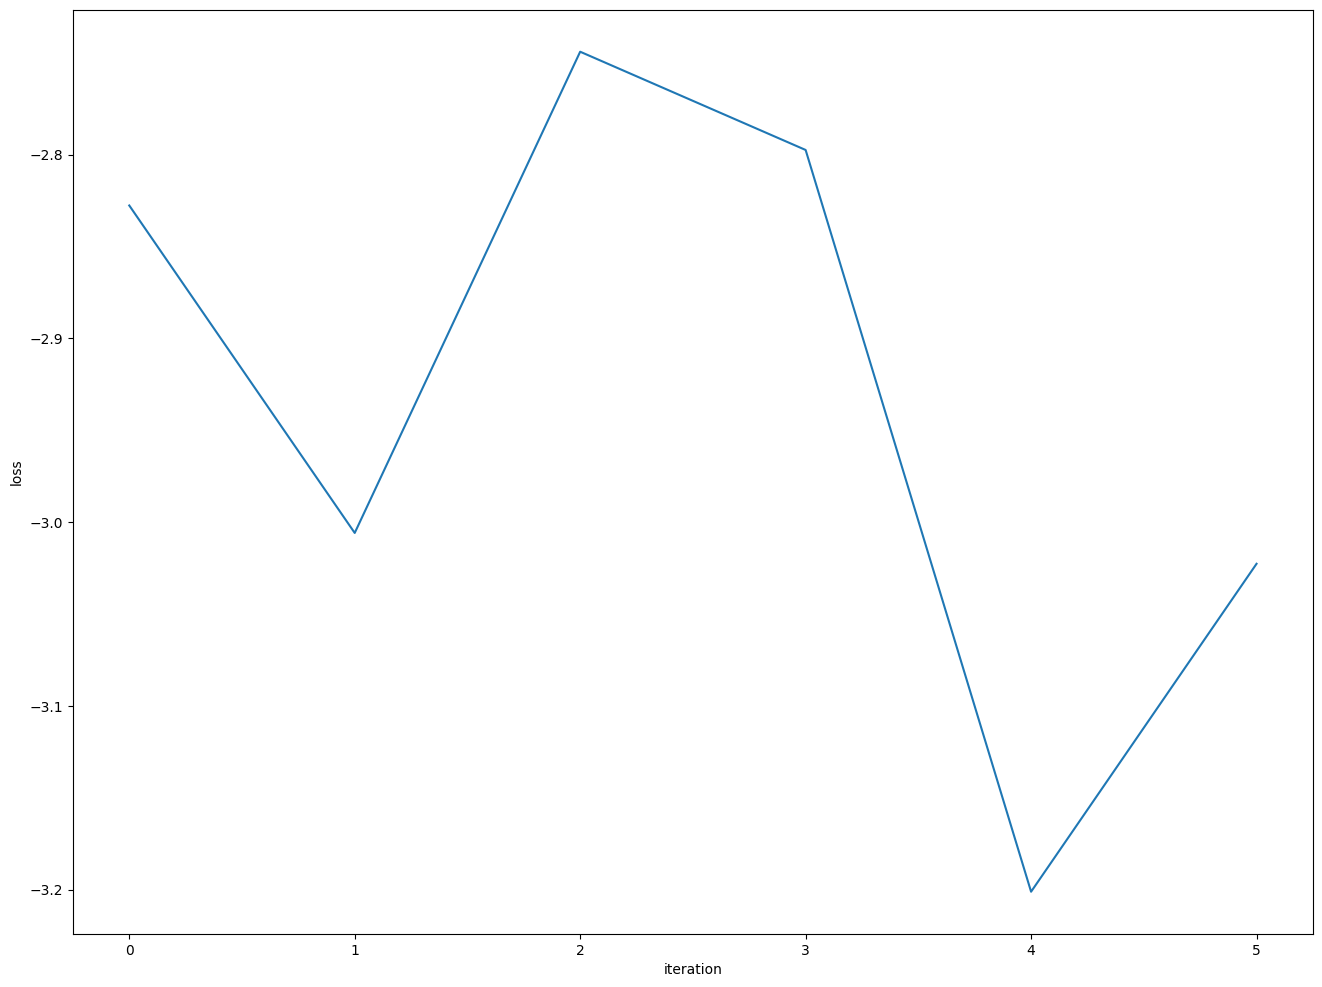

In [56]:
normalized_loss_array = np.array(normalized_loss_list)
plt.figure(figsize=(16,12))
plt.plot(normalized_loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".png")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".eps")